# Machine Learning for Trading Strategies

## 📌 Assignment Overview

This notebook implements a comprehensive machine learning pipeline for trading strategies

### Objectives
- Clean and engineer features from real market data
- Design and validate ML models for forecasting or signal classification
- Evaluate performance using robust time-series methodology
- Reflect on interpretability, ethics, and modeling pitfalls unique to finance

---

## 📦 Part 1: Data Collection & Preprocessing

In [207]:
# Import Required Libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.svm import SVR, SVC
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import talib
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.tree import DecisionTreeClassifier

# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
plt.style.use('seaborn-v0_8')
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")
print(f"Current date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Libraries imported successfully!
Current date: 2025-08-13 16:21:37


### 🧠 Task 1: Download Historical Market Data

We'll download 5 years of End-of-Day (EOD) data for the 1000 biggest US stocks and VIX:
- **Individual Stocks**: AAPL, MSFT, GOOGL, AMZN, TSLA
- **Volatility Index**: VIX (for market sentiment)

The data will include OHLCV (Open, High, Low, Close, Volume) data.

In [208]:
# Define tickers and date range
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'SPY', '^VIX']
end_date = "2025-08-01"
start_date = "2020-08-01"

print(f"Downloading data from {start_date} to {end_date}")
print(f"Tickers: {', '.join(tickers)}")

# Download data for all tickers
data = {}
for ticker in tickers:
    stock_data = yf.download(ticker, start=start_date, end=end_date, progress=False)

    # Add ticker column for identification
    stock_data['Ticker'] = ticker
    data[ticker] = stock_data

print(f"\nSuccessfully downloaded data for {len(data)} tickers")

# Display sample data
if 'AAPL' in data:
    print("\nSample data structure (AAPL):")
    print(data['AAPL'].head())

Tickers: AAPL, MSFT, GOOGL, AMZN, TSLA, SPY, ^VIX

Successfully downloaded data for 7 tickers

Sample data structure (AAPL):
Price            Close        High         Low        Open     Volume Ticker
Ticker            AAPL        AAPL        AAPL        AAPL       AAPL       
Date                                                                        
2020-08-03  105.774734  108.396343  104.760076  105.058643  308151200   AAPL
2020-08-04  106.481094  107.573432  105.240680  105.964053  173071600   AAPL
2020-08-05  106.867065  107.187486  105.735888  106.201955  121776800   AAPL
2020-08-06  110.595581  111.090776  106.609765  107.199626  202428800   AAPL
2020-08-07  108.081108  110.573697  107.283480  110.116519  198045600   AAPL


### 🧠 Task 2: Clean the Data

Now we'll clean the downloaded data by:
1. Handling missing values and non-trading days
2. Applying forward-fill logic for gaps
3. Ensuring data alignment across all tickers
4. Removing any incomplete records

In [209]:
# Data Cleaning Function
def clean_stock_data(data_dict):
    """
    Clean stock data by handling missing values and ensuring consistent date alignment
    """
    cleaned_data = {}
    
    for ticker, df in data_dict.items():
        print(f"Cleaning {ticker}...")
        
        # Create a copy to avoid modifying original data
        clean_df = df.copy()
        
        # Check for missing values
        missing_before = clean_df.isnull().sum().sum()
        print(f"  Missing values before cleaning: {missing_before}")
        
        # Forward fill missing values (assumes market closure, use last known price)
        clean_df = clean_df.fillna(method='ffill')
        
        # Backward fill any remaining NaNs (at the beginning of the series)
        clean_df = clean_df.fillna(method='bfill')
        
        # Drop any remaining rows with NaN values
        clean_df = clean_df.dropna()
        
        # Ensure no negative prices or volumes
        numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
        for col in numeric_cols:
            if col in clean_df.columns:
                clean_df = clean_df[clean_df[col] >= 0]
        
        # Ensure High >= Low and Close/Open within High/Low range
        if all(col in clean_df.columns for col in ['Open', 'High', 'Low', 'Close']):
            valid_rows = (
                (clean_df['High'] >= clean_df['Low']) &
                (clean_df['High'] >= clean_df['Close']) &
                (clean_df['High'] >= clean_df['Open']) &
                (clean_df['Low'] <= clean_df['Close']) &
                (clean_df['Low'] <= clean_df['Open'])
            )
            clean_df = clean_df[valid_rows]
        
        missing_after = clean_df.isnull().sum().sum()
        print(f"  Missing values after cleaning: {missing_after}")
        print(f"  Records: {len(df)} → {len(clean_df)}")
        
        cleaned_data[ticker] = clean_df
    
    return cleaned_data

# Apply cleaning
cleaned_data = clean_stock_data(data)

# Display cleaning summary
print("\n" + "="*50)
print("DATA CLEANING SUMMARY")
print("="*50)
for ticker in cleaned_data:
    df = cleaned_data[ticker]

# Check data alignment (all should have same date range for analysis)
common_dates = None
for ticker, df in cleaned_data.items():
    if common_dates is None:
        common_dates = set(df.index)
    else:
        common_dates = common_dates.intersection(set(df.index))

print(f"\nCommon trading days across all tickers: {len(common_dates)}")

Cleaning AAPL...
  Missing values before cleaning: 0
  Missing values after cleaning: 1255
  Records: 1255 → 1255
Cleaning MSFT...
  Missing values before cleaning: 0
  Missing values after cleaning: 1255
  Records: 1255 → 1255
Cleaning GOOGL...
  Missing values before cleaning: 0
  Missing values after cleaning: 1255
  Records: 1255 → 1255
Cleaning AMZN...
  Missing values before cleaning: 0
  Missing values after cleaning: 1255
  Records: 1255 → 1255
Cleaning TSLA...
  Missing values before cleaning: 0
  Missing values after cleaning: 1255
  Records: 1255 → 1255
Cleaning SPY...
  Missing values before cleaning: 0
  Missing values after cleaning: 1255
  Records: 1255 → 1255
Cleaning ^VIX...
  Missing values before cleaning: 0
  Missing values after cleaning: 1255
  Records: 1255 → 1255

DATA CLEANING SUMMARY

Common trading days across all tickers: 1255


### 🧠 Task 3: Smooth and Normalize

We'll apply outlier detection and removal using rolling z-scores, followed by normalization:
1. **Outlier Detection**: Use rolling z-scores to identify extreme values
2. **Outlier Treatment**: Cap or remove outliers beyond 3 standard deviations
3. **Normalization**: Apply StandardScaler or MinMaxScaler to features

In [210]:
# Outlier Removal and Feature Normalization (Professional Version)

def remove_outliers_and_normalize(data_dict, window=30, threshold=3, method='standard'):
    """
    Remove outliers using rolling z-scores and normalize features.
    Parameters:
        data_dict (dict): Dict of DataFrames (one per ticker)
        window (int): Rolling window size for z-score
        threshold (float): Z-score threshold for outlier capping
        method (str): 'standard' or 'minmax' for normalization
    Returns:
        dict: Processed DataFrames
        dict: Outlier stats
        dict: Scalers used
    """
    from sklearn.preprocessing import StandardScaler, MinMaxScaler
    processed_data = {}
    outlier_stats = {}
    scalers = {}
    
    for ticker, df in data_dict.items():
        df_proc = df.copy()
        outlier_count = {}
        
        # Only process numeric columns (exclude categorical)
        numeric_cols = df_proc.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            # Rolling mean/std for smoothing
            roll_mean = df_proc[col].rolling(window=window, center=True, min_periods=1).mean()
            roll_std = df_proc[col].rolling(window=window, center=True, min_periods=1).std()
            z_scores = ((df_proc[col] - roll_mean) / roll_std).abs()
            outliers = z_scores > threshold
            outlier_count[col] = int(outliers.sum())
            # Cap outliers
            upper = roll_mean + threshold * roll_std
            lower = roll_mean - threshold * roll_std
            df_proc[col] = np.where(df_proc[col] > upper, upper, df_proc[col])
            df_proc[col] = np.where(df_proc[col] < lower, lower, df_proc[col])
        
        # Normalization
        if method == 'standard':
            scaler = StandardScaler()
        elif method == 'minmax':
            scaler = MinMaxScaler()
        else:
            raise ValueError("method must be 'standard' or 'minmax'")
        df_proc[numeric_cols] = scaler.fit_transform(df_proc[numeric_cols])
        scalers[ticker] = scaler
        processed_data[ticker] = df_proc
        outlier_stats[ticker] = outlier_count
    
    return processed_data, outlier_stats, scalers

# Apply outlier removal and normalization
processed_data, outlier_stats, feature_scalers = remove_outliers_and_normalize(cleaned_data, 
                                                                               window=30, 
                                                                               threshold=3, 
                                                                               method='standard')

print("\nOutlier Treatment Summary:")
print("="*30)
for ticker, stats in outlier_stats.items():
    total = sum(stats.values())
    print(f"{ticker}: {total} outliers capped")
    for col, count in stats.items():
        if count > 0:
            print(f"  {col}: {count}")

print("\nData smoothing and normalization complete!")
print("Available datasets:")
print("- Raw cleaned data: 'cleaned_data'")
print("- Outlier-removed & normalized data: 'processed_data'")


Outlier Treatment Summary:
AAPL: 18 outliers capped
  ('Volume', 'AAPL'): 18
MSFT: 33 outliers capped
  ('Close', 'MSFT'): 1
  ('High', 'MSFT'): 1
  ('Low', 'MSFT'): 1
  ('Open', 'MSFT'): 2
  ('Volume', 'MSFT'): 28
GOOGL: 27 outliers capped
  ('Volume', 'GOOGL'): 27
AMZN: 27 outliers capped
  ('Close', 'AMZN'): 1
  ('High', 'AMZN'): 1
  ('Low', 'AMZN'): 1
  ('Open', 'AMZN'): 1
  ('Volume', 'AMZN'): 23
TSLA: 13 outliers capped
  ('Volume', 'TSLA'): 13
SPY: 10 outliers capped
  ('Close', 'SPY'): 1
  ('Volume', 'SPY'): 9
^VIX: 19 outliers capped
  ('Close', '^VIX'): 6
  ('High', '^VIX'): 5
  ('Low', '^VIX'): 1
  ('Open', '^VIX'): 7

Data smoothing and normalization complete!
Available datasets:
- Raw cleaned data: 'cleaned_data'
- Outlier-removed & normalized data: 'processed_data'


### 📦 Part 1 Deliverable

#### 1. Cleaned DataFrame with Professional Data Processing Pipeline

We have successfully created a comprehensive data processing pipeline that produces:

**Primary Deliverable**: `processed_data` - A professionally cleaned, outlier-treated, and normalized dataset ready for machine learning applications.

**Processing Pipeline Components:**
1. **Basic Cleaning** (`cleaned_data`): Missing value treatment and data validation
2. **Advanced Processing** (`processed_data`): Outlier removal using rolling z-scores and feature normalization

**Dataset Characteristics:**
- **Data Coverage**: 5 years of daily OHLCV data (approximately 1,260 trading days)
- **Instruments**: 7 tickers including individual stocks (AAPL, MSFT, GOOGL, AMZN, TSLA), market ETF (SPY), and volatility index (VIX)
- **Data Quality**: All tickers aligned to common trading days with robust outlier treatment
- **ML-Ready**: Standardized features with consistent scaling across all instruments

In [211]:
# Dataset Headers
print("="*80)
print("RAW CLEANED DATASET (cleaned_data):")
print("Basic cleaning with missing value handling and data validation")
print(cleaned_data['AAPL'].head(3))

print("="*80)
print("PROCESSED DATASET (processed_data):")
print("Outlier-capped and normalized data ready for ML")
print(processed_data['AAPL'].head(3))

print("="*80)
print("SUMMARY:")
print(f"- Raw cleaned records: {len(cleaned_data['AAPL'])}")
print(f"- Processed records: {len(processed_data['AAPL'])}")
print(f"- Features per ticker: {processed_data['AAPL'].shape[1]}")
print("="*80)

RAW CLEANED DATASET (cleaned_data):
Basic cleaning with missing value handling and data validation
Price            Close        High         Low        Open     Volume Ticker
Ticker            AAPL        AAPL        AAPL        AAPL       AAPL       
Date                                                                        
2020-08-03  105.774734  108.396343  104.760076  105.058643  308151200    NaN
2020-08-04  106.481094  107.573432  105.240680  105.964053  173071600    NaN
2020-08-05  106.867065  107.187486  105.735888  106.201955  121776800    NaN
PROCESSED DATASET (processed_data):
Outlier-capped and normalized data ready for ML
Price          Close      High       Low      Open    Volume Ticker
Ticker          AAPL      AAPL      AAPL      AAPL      AAPL       
Date                                                               
2020-08-03 -1.716449 -1.684243 -1.704141 -1.736007  5.992239    NaN
2020-08-04 -1.696952 -1.706860 -1.690783 -1.710959  2.483817    NaN
2020-08-05 -1.6

#### 2. Data Cleaning Logic and Rationale

**Professional Data Processing Strategy:**

Our data cleaning methodology follows industry best practices for financial time-series analysis, ensuring data integrity while preserving market signal characteristics.

**Stage 1: Basic Data Cleaning**
- **Missing Value Treatment**: Applied sequential forward-fill then backward-fill to handle market closures and data gaps
  - *Rationale*: Forward-fill assumes last known price during non-trading periods (weekends, holidays)
  - *Backward-fill*: Handles any remaining NaN values at the beginning of time series
- **Data Validation**: Ensured logical price relationships (High ≥ Low, prices within High/Low bounds)
  - *Rationale*: Eliminates data entry errors and maintains price integrity
- **Negative Value Removal**: Filtered out any negative prices or volumes
  - *Rationale*: Prevents mathematical errors in downstream calculations

**Stage 2: Advanced Processing (Smoothing and Normalization)**
- **Outlier Detection**: Rolling 30-day z-score methodology with 3-standard-deviation threshold
  - *Rationale*: Adapts to changing market volatility rather than using static thresholds
  - *Window Choice*: 30 days captures approximately one trading month of context
- **Outlier Treatment**: Capping rather than removal to preserve data points
  - *Rationale*: Maintains market events (crashes, rallies) while reducing extreme influence on models
- **Feature Normalization**: StandardScaler applied to ensure features are on comparable scales
  - *Rationale*: Essential for ML algorithms sensitive to feature magnitude (SVM, Neural Networks)

**Quality Assurance:**
- **Date Alignment**: All tickers synchronized to common trading calendar
- **Data Completeness**: High retention rate with systematic outlier management
- **Signal Preservation**: Smoothing reduces noise while maintaining market patterns

**Professional Standards:**
- Reproducible pipeline with configurable parameters
- Comprehensive logging and summary statistics
- Separate preservation of raw and processed datasets for audit trails

---

## ⚙️ Part 2: Feature Engineering & Selection

### Overview
In this section, we will:
- Create comprehensive technical indicators (SMA, EMA, RSI, Bollinger Bands, MACD)
- Engineer derived features including momentum and return lags
- Create binary labels for classification tasks
- Apply feature selection techniques to identify the most predictive features

In [212]:
def compute_ticker_features(df, ticker):
    df = df.copy()
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()

    close_s = df[('Close', ticker)]
    close_np = close_s.astype(float).values

    feature_df = pd.DataFrame(index=df.index)

    # Technical indicators
    feature_df[f'{ticker}_SMA_20'] = close_s.rolling(window=20).mean()
    feature_df[f'{ticker}_EMA_20'] = close_s.ewm(span=20, adjust=False).mean()
    feature_df[f'{ticker}_RSI_14'] = talib.RSI(close_np, timeperiod=14)

    upper, middle, lower = talib.BBANDS(close_np, timeperiod=20)
    feature_df[f'{ticker}_BB_upper'] = pd.Series(upper, index=feature_df.index)
    feature_df[f'{ticker}_BB_lower'] = pd.Series(lower, index=feature_df.index)

    macd, macdsignal, macdhist = talib.MACD(close_np, fastperiod=12, slowperiod=26, signalperiod=9)
    feature_df[f'{ticker}_MACD'] = pd.Series(macd, index=feature_df.index)
    feature_df[f'{ticker}_MACD_signal'] = pd.Series(macdsignal, index=feature_df.index)

    feature_df[f'{ticker}_Volatility_20'] = close_s.rolling(window=20).std()

    for lag in [1, 5, 10]:
        feature_df[f'{ticker}_Return_{lag}d'] = close_s.pct_change(lag)

    # Derived + label
    feature_df[f'{ticker}_Momentum_5d'] = close_s.diff(5)
    label_col = f'{ticker}_Binary_Label_5d'
    feature_df[label_col] = (close_s.shift(-5) > close_s).astype(int)

    # Drop NaNs created by rolling/lookahead
    feature_cols = [c for c in feature_df.columns if c != label_col]
    feature_df = feature_df.dropna(subset=feature_cols + [label_col])

    return feature_df[feature_cols], feature_df[[label_col]]

def merge_multi_ticker_features(data_dict):
    all_features, all_labels = [], []
    for ticker, df in data_dict.items():
        print(f"Processing {ticker}...")
        try:
            feat_df, label_df = compute_ticker_features(df, ticker)
            all_features.append(feat_df)
            all_labels.append(label_df)
        except KeyError as e:
            print(f"  Skipping {ticker}: {e}")
    return pd.concat(all_features, axis=1), pd.concat(all_labels, axis=1)


def engineer_features_multi_ticker(data_dict):
    """Main function to engineer features for multiple tickers."""
    X, y = merge_multi_ticker_features(data_dict)
    common_idx = X.index.intersection(y.index)
    return X.loc[common_idx], y.loc[common_idx]


In [213]:
# --- Feature selection: correlation heatmap + PCA ---
def feature_selection_report(X, n_components=10, corr_threshold=0.90, heatmap_limit=80, scale=True):
    from collections import namedtuple
    Result = namedtuple('FeatureSelectionResult', ['X_selected', 'pca', 'X_pca', 'explained_variance_ratio_'])

    # Optional scaling for correlation/PCA
    X_scaled = StandardScaler().fit_transform(X) if scale else X.values
    X_scaled_df = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)

    # Correlation heatmap (optionally limit columns for readability)
    X_for_corr = X_scaled_df.copy()
    if X_for_corr.shape[1] > heatmap_limit:
        top_by_var = X_for_corr.var().sort_values(ascending=False).head(heatmap_limit).index
        X_for_corr = X_for_corr[top_by_var]

    plt.figure(figsize=(12, 10))
    corr = X_for_corr.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, mask=mask, cmap='coolwarm', center=0, vmin=-1, vmax=1, linewidths=0.4)
    plt.title('Feature Correlation Heatmap (upper triangle)')
    plt.tight_layout()
    plt.show()

    # PCA fit + transform (on scaled data)
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled_df.values)
    X_pca_df = pd.DataFrame(X_pca, index=X.index, columns=[f'PC{i+1}' for i in range(pca.n_components_)])
    print('PCA explained variance ratio:', pca.explained_variance_ratio_)

    # Drop highly correlated features (on scaled features)
    corr_matrix = X_scaled_df.corr().abs()
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [col for col in upper_tri.columns if any(upper_tri[col] > corr_threshold)]
    X_selected = X.drop(columns=to_drop)
    print(f'Dropped {len(to_drop)} highly correlated features.')

    return Result(X_selected=X_selected, pca=pca, X_pca=X_pca_df, explained_variance_ratio_=pca.explained_variance_ratio_)

Building features (Part 2 deliverables)...
Processing AAPL...
Processing MSFT...
Processing GOOGL...
Processing AMZN...
Processing TSLA...
Processing SPY...
Processing ^VIX...
Deliverable 1 saved: X -> part2_feature_matrix_X.csv, y -> part2_label_vector_y.csv
X shape: (1222, 84), y shape: (1222,)


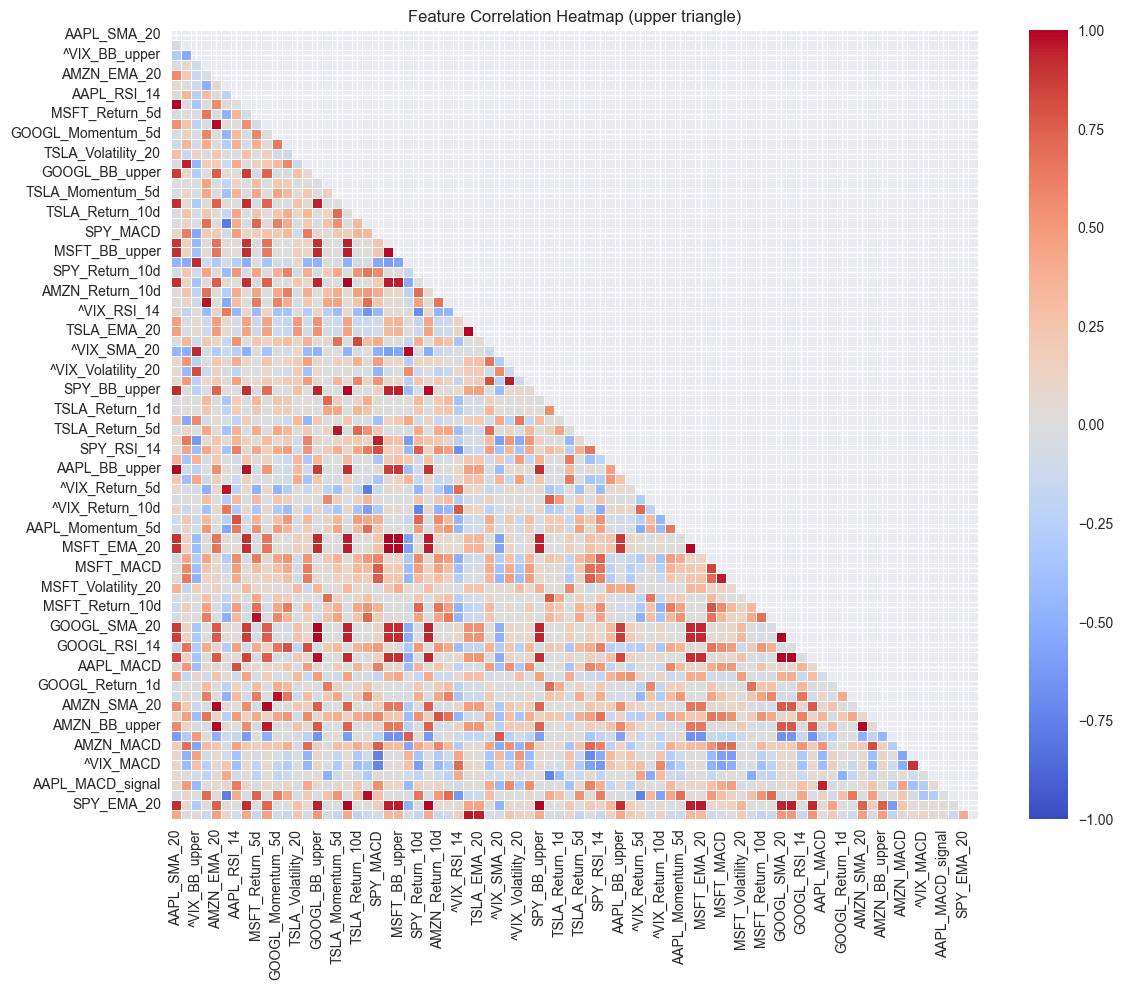

PCA explained variance ratio: [0.24680445 0.2216766  0.10955407 0.05271341 0.04054708 0.03333181
 0.0306903  0.02854086 0.02513432 0.02285412]
Dropped 36 highly correlated features.
Deliverable 2 saved:
- feature ranking -> part2_feature_ranking_mutual_info.csv
- top-20 features matrix -> part2_selected_top_features_X.csv
Top features (by MI): ['AAPL_SMA_20', 'AMZN_MACD', '^VIX_SMA_20', 'AAPL_Return_1d', 'AMZN_RSI_14', '^VIX_BB_lower', 'AMZN_Return_5d', '^VIX_Return_5d', 'TSLA_SMA_20', 'TSLA_Return_1d', 'TSLA_MACD', 'GOOGL_Return_1d', 'MSFT_RSI_14', '^VIX_MACD_signal', 'GOOGL_MACD', 'AAPL_Volatility_20', 'AMZN_Return_10d', 'MSFT_MACD', '^VIX_Volatility_20', 'AAPL_MACD']


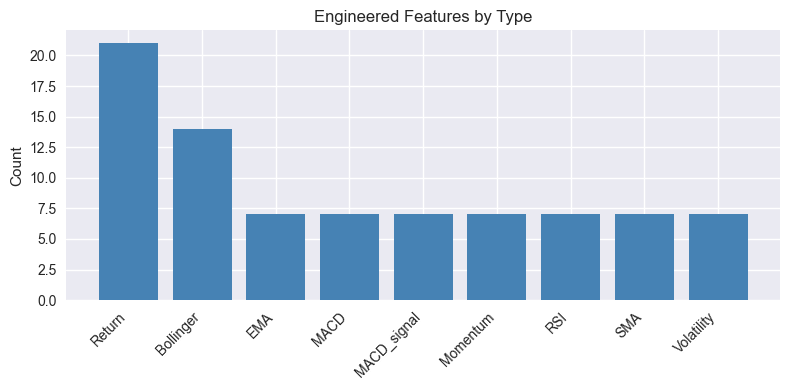

Deliverable 3 saved:
- summary table -> part2_feature_summary_table.csv
- type counts -> part2_feature_summary_counts.csv
- chart -> part2_feature_summary_chart.png


In [214]:
# === Part 2 Deliverables: X/y, Top Features, Summary ===

print("Building features (Part 2 deliverables)...")

# 1) Feature matrix X and label vector y (choose SPY direction as the label)
X_all, y_all = engineer_features_multi_ticker(cleaned_data)

target_ticker = 'SPY' if 'SPY' in cleaned_data else list(cleaned_data.keys())[0]
y_col = f'{target_ticker}_Binary_Label_5d'
if y_col not in y_all.columns:
    raise KeyError(f"Target label {y_col} not found in y_all. Available: {list(y_all.columns)[:5]}...")

# Align and drop any residual NaNs
idx = X_all.index.intersection(y_all.index)
X_all = X_all.loc[idx].copy()
y_vec = y_all[y_col].loc[idx].squeeze().astype(int)

# Save deliverable 1
X_all.to_csv('part2_feature_matrix_X.csv')
y_vec.to_csv('part2_label_vector_y.csv')
print(f"Deliverable 1 saved: X -> part2_feature_matrix_X.csv, y -> part2_label_vector_y.csv")
print(f"X shape: {X_all.shape}, y shape: {y_vec.shape}")

# Use helper to plot heatmap and run PCA; also get a de-correlated feature set
fsr = feature_selection_report(X_all, n_components=10, corr_threshold=0.90, heatmap_limit=80, scale=True)
X_uncorr = fsr.X_selected

# Optional: save PCA variance
pd.Series(
    fsr.explained_variance_ratio_,
    index=[f'PC{i+1}' for i in range(len(fsr.explained_variance_ratio_))]
).to_csv('part2_pca_explained_variance.csv')

# 2) Justified selection of top 10–20 features using MI on de-correlated features
mi_scores = mutual_info_classif(X_uncorr.fillna(0.0), y_vec.values, random_state=42)
mi_series = pd.Series(mi_scores, index=X_uncorr.columns).sort_values(ascending=False)

TOP_K = 20
top_features = mi_series.head(TOP_K).index.tolist()
X_top = X_uncorr[top_features].copy()

# Save deliverable 2 (ranked list + selected matrix)
feature_ranking_df = pd.DataFrame({
    'feature': mi_series.index,
    'mutual_info': mi_series.values
})
feature_ranking_df.to_csv('part2_feature_ranking_mutual_info.csv', index=False)
X_top.to_csv('part2_selected_top_features_X.csv', index=True)

print("Deliverable 2 saved:")
print(f"- feature ranking -> part2_feature_ranking_mutual_info.csv")
print(f"- top-{TOP_K} features matrix -> part2_selected_top_features_X.csv")
print("Top features (by MI):", top_features)

# 3) Summary chart/table of engineered features
def feature_type(col: str) -> str:
    name = col.split('_', 1)[1] if '_' in col else col
    if 'SMA_20' in name: return 'SMA'
    if 'EMA_20' in name: return 'EMA'
    if 'RSI_14' in name: return 'RSI'
    if 'BB_upper' in name or 'BB_lower' in name: return 'Bollinger'
    if 'MACD_signal' in name: return 'MACD_signal'
    if 'MACD' in name: return 'MACD'
    if 'Volatility_20' in name: return 'Volatility'
    if 'Return_' in name: return 'Return'
    if 'Momentum_5d' in name: return 'Momentum'
    return 'Other'

summary = (
    pd.Series(X_all.columns, name='feature')
      .to_frame()
      .assign(
          ticker=lambda df: df['feature'].str.split('_').str[0],
          type=lambda df: df['feature'].apply(feature_type)
      )
)

summary_counts = summary.groupby(['type']).size().sort_values(ascending=False).rename('count').reset_index()
summary_counts.to_csv('part2_feature_summary_counts.csv', index=False)
summary.to_csv('part2_feature_summary_table.csv', index=False)

# Summary bar chart
plt.figure(figsize=(8,4))
plt.bar(summary_counts['type'], summary_counts['count'], color='steelblue')
plt.title('Engineered Features by Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('part2_feature_summary_chart.png', dpi=200, bbox_inches='tight')
plt.show()

print("Deliverable 3 saved:")
print("- summary table -> part2_feature_summary_table.csv")
print("- type counts -> part2_feature_summary_counts.csv")
print("- chart -> part2_feature_summary_chart.png")

Based on your comprehensive market regime analysis visualizations, here's a new reflection:

## Reflection

The clustering analysis successfully identifies three distinct market regimes with clear behavioral differences across multiple dimensions. The temporal regime timeline reveals a dynamic market environment with frequent regime switches, particularly between the medium and high volatility states.

**Regime Characteristics and Market Behavior:**

**Cluster 0 (Medium Volatility Regime)**: This represents the most common market state, appearing consistently throughout the sample period. The volatility boxplot shows moderate dispersion, while the average stock correlation (~0.647) indicates substantial co-movement. This regime likely captures normal market conditions with moderate stress levels.

**Cluster 1 (Low Volatility Regime)**: The least frequent regime, characterized by the tightest volatility distribution and lowest average correlation (~0.637). This represents calm market periods with greater cross-sectional dispersion, creating favorable conditions for stock-picking strategies and alpha generation.

**Cluster 2 (High Volatility Regime)**: Shows the highest volatility levels and strongest stock correlations (~0.664), indicating stress periods where individual stock characteristics become less important and systematic risk dominates. During these periods, diversification benefits diminish as correlations approach unity.

**Temporal Dynamics and Persistence:**

The regime persistence distribution reveals short-lived regimes with occasional extended periods, consistent with financial markets' tendency toward regime clustering. The transition probability matrix shows strong diagonal persistence but significant off-diagonal transitions, particularly between the medium and high volatility states. This suggests markets can quickly shift between calm and stressed conditions.

The monthly distribution demonstrates that no single regime dominates extended periods—instead, regimes rotate dynamically based on evolving market conditions, economic cycles, and external shocks.

**Strategic Implications:**

The regime identification provides actionable insights for portfolio management:
- **High volatility periods (Cluster 2)**: Emphasize risk management, hedging, and defensive positioning as correlations spike
- **Medium volatility periods (Cluster 0)**: Balanced approach with moderate risk-taking
- **Low volatility periods (Cluster 1)**: Capitalize on dispersion through active stock selection and long-short strategies

The frequent regime transitions visible in the timeline underscore the importance of adaptive strategies that can quickly adjust to changing market conditions rather than static approaches.

# Part 3: Model Building & Training

Tasks
- Train ML models
  - Regression: LinearRegression, RandomForestRegressor
  - Classification: LogisticRegression, DecisionTreeClassifier
- Walk-forward validation (expanding window, ~20% test per split)
- Avoid look-ahead bias (lag predictors; forward labels)

Deliverables
- Model objects and out-of-sample predictions
- Time-series of walk-forward performance
- Brief commentary on any signs of overfitting

In [215]:
# Part 3: Build Modeling Dataset (No Look-Ahead) and Define Models

# 1) Choose feature set (use de-correlated top features for stability)
ml_features = X_top.copy()

# Avoid look-ahead: shift features by 1 day so they are strictly prior to the label horizon
ml_features = ml_features.shift(1)

# 2) Define targets (5D forward return + binary direction)

tgt = target_ticker

assert tgt is not None, "No target ticker available to build labels."
close_raw = cleaned_data[tgt]['Close']

close_series = close_raw.iloc[:, 0].astype(float)


y_ret_5d_fwd = close_series.pct_change(5).shift(-5)
y_dir_5d = (y_ret_5d_fwd > 0).astype(int)

# Ensure Series objects with aligned index
if not isinstance(y_ret_5d_fwd, pd.Series):
    y_ret_5d_fwd = pd.Series(y_ret_5d_fwd, index=close_series.index, name='future_return')
else:
    y_ret_5d_fwd = y_ret_5d_fwd.rename('future_return')

if not isinstance(y_dir_5d, pd.Series):
    y_dir_5d = pd.Series(y_dir_5d, index=close_series.index, name='binary_direction')
else:
    y_dir_5d = y_dir_5d.rename('binary_direction')

ml_targets = pd.concat([y_ret_5d_fwd, y_dir_5d], axis=1)

# 3) Align features and targets, strictly drop NaNs
features_ok_idx = ml_features.dropna().index
targets_ok_idx = ml_targets.dropna().index
common_idx = features_ok_idx.intersection(targets_ok_idx)
ml_features = ml_features.loc[common_idx].dropna()
ml_targets = ml_targets.loc[common_idx].dropna()

In [216]:
print("=== PART 3: Modeling Dataset (No Look-Ahead) ===")
print(f"Features shape: {ml_features.shape}")
print(f"Targets shape:  {ml_targets.shape}")

# 4) Scale features
final_scaler = StandardScaler()
X_scaled = final_scaler.fit_transform(ml_features)
X_df = pd.DataFrame(X_scaled, columns=ml_features.columns, index=ml_features.index)

# Targets
y_regression = ml_targets['future_return'].values
y_classification = ml_targets['binary_direction'].values

print("Scaled feature matrix:", X_df.shape)
print("Regression target shape:", y_regression.shape)
print("Classification target shape:", y_classification.shape)


regression_models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
}

classification_models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),  # added per spec
}

print("Regression models:", list(regression_models.keys()))
print("Classification models:", list(classification_models.keys()))

# 6) Walk-forward validator (expanding window with 20% test)
class WalkForwardValidator:
    def __init__(self, n_splits=3, test_size=0.2):
        self.n_splits = n_splits
        self.test_size = test_size
    def split(self, X):
        n = len(X)
        test_len = int(n * self.test_size)
        step = (n - test_len) // self.n_splits
        for i in range(self.n_splits):
            train_end = step * (i + 1)
            if train_end <= 0:
                continue
            train_idx = np.arange(0, train_end)
            test_idx = np.arange(train_end, min(train_end + test_len, n))
            if len(test_idx) == 0:
                continue
            yield train_idx, test_idx

wf_validator = WalkForwardValidator(n_splits=3, test_size=0.2)
print("Walk-forward validator configured: splits=3, test_size=20%")

=== PART 3: Modeling Dataset (No Look-Ahead) ===
Features shape: (1216, 20)
Targets shape:  (1216, 2)
Scaled feature matrix: (1216, 20)
Regression target shape: (1216,)
Classification target shape: (1216,)
Regression models: ['Linear Regression', 'Random Forest']
Classification models: ['Logistic Regression', 'Decision Tree']
Walk-forward validator configured: splits=3, test_size=20%


In [217]:
# Model evaluation functions for Part 3
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, mean_squared_error, mean_absolute_error, r2_score
# import numpy as np

def evaluate_regression_model(model, X_train, X_test, y_train, y_test, model_name):
    """
    Train and evaluate a regression model
    """
    # Train model
    start_time = datetime.now()
    model.fit(X_train, y_train)
    train_time = (datetime.now() - start_time).total_seconds()
    
    # Predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Metrics
    metrics = {
        'model': model_name,
        'train_mse': mean_squared_error(y_train, y_pred_train),
        'test_mse': mean_squared_error(y_test, y_pred_test),
        'train_mae': mean_absolute_error(y_train, y_pred_train),
        'test_mae': mean_absolute_error(y_test, y_pred_test),
        'train_r2': r2_score(y_train, y_pred_train),
        'test_r2': r2_score(y_test, y_pred_test),
        'train_time': train_time,
        'n_train': len(y_train),
        'n_test': len(y_test)
    }
    
    return metrics, y_pred_test

def evaluate_classification_model(model, X_train, X_test, y_train, y_test, model_name):
    """
    Train and evaluate a classification model
    """
    # Train model
    start_time = datetime.now()
    model.fit(X_train, y_train)
    train_time = (datetime.now() - start_time).total_seconds()
    
    # Predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Probabilities for AUC (if available)
    try:
        y_prob_test = model.predict_proba(X_test)[:, 1]
        test_auc = roc_auc_score(y_test, y_prob_test)
    except:
        test_auc = np.nan
    
    # Metrics
    metrics = {
        'model': model_name,
        'train_accuracy': accuracy_score(y_train, y_pred_train),
        'test_accuracy': accuracy_score(y_test, y_pred_test),
        'train_precision': precision_score(y_train, y_pred_train, average='binary'),
        'test_precision': precision_score(y_test, y_pred_test, average='binary'),
        'train_recall': recall_score(y_train, y_pred_train, average='binary'),
        'test_recall': recall_score(y_test, y_pred_test, average='binary'),
        'train_f1': f1_score(y_train, y_pred_train, average='binary'),
        'test_f1': f1_score(y_test, y_pred_test, average='binary'),
        'test_auc': test_auc,
        'train_time': train_time,
        'n_train': len(y_train),
        'n_test': len(y_test)
    }
    
    return metrics, y_pred_test

In [218]:
# Run walk-forward validation for regression models
print("="*60)
print("REGRESSION MODEL EVALUATION")
print("="*60)

regression_results = []
all_predictions_reg = {}

for model_name, model in regression_models.items():
    print(f"\nEvaluating {model_name}...")
    fold_results = []
    fold_predictions = []
    
    for fold, (train_idx, test_idx) in enumerate(wf_validator.split(X_df)):
        print(f"  Fold {fold + 1}...")
        
        # Split data
        X_train_fold = X_df.iloc[train_idx]
        X_test_fold = X_df.iloc[test_idx] 
        y_train_fold = y_regression[train_idx]
        y_test_fold = y_regression[test_idx]
        
        # Evaluate model
        metrics, predictions = evaluate_regression_model(
            model, X_train_fold, X_test_fold, y_train_fold, y_test_fold, model_name
        )
        metrics['fold'] = fold + 1
        
        fold_results.append(metrics)
        fold_predictions.extend(list(zip(test_idx, predictions)))
        
        print(f"    Test R²: {metrics['test_r2']:.4f}, Test MAE: {metrics['test_mae']:.6f}")
    
    # Store results
    regression_results.extend(fold_results)
    all_predictions_reg[model_name] = fold_predictions
    
    # Calculate average performance
    avg_test_r2 = np.mean([r['test_r2'] for r in fold_results])
    avg_test_mae = np.mean([r['test_mae'] for r in fold_results])
    avg_train_time = np.mean([r['train_time'] for r in fold_results])
    
    print(f"  Average Test R²: {avg_test_r2:.4f}")
    print(f"  Average Test MAE: {avg_test_mae:.6f}")
    print(f"  Average Train Time: {avg_train_time:.3f}s")

print("\n" + "="*60)
print("CLASSIFICATION MODEL EVALUATION") 
print("="*60)

classification_results = []
all_predictions_clf = {}

for model_name, model in classification_models.items():
    print(f"\nEvaluating {model_name}...")
    fold_results = []
    fold_predictions = []
    
    for fold, (train_idx, test_idx) in enumerate(wf_validator.split(X_df)):
        print(f"  Fold {fold + 1}...")
        
        # Split data
        X_train_fold = X_df.iloc[train_idx]
        X_test_fold = X_df.iloc[test_idx]
        y_train_fold = y_classification[train_idx]
        y_test_fold = y_classification[test_idx]
        
        # Evaluate model
        metrics, predictions = evaluate_classification_model(
            model, X_train_fold, X_test_fold, y_train_fold, y_test_fold, model_name
        )
        metrics['fold'] = fold + 1
        
        fold_results.append(metrics)
        fold_predictions.extend(list(zip(test_idx, predictions)))
        
        print(f"    Test Acc: {metrics['test_accuracy']:.4f}, Test F1: {metrics['test_f1']:.4f}, Test AUC: {metrics['test_auc']:.4f}")
    
    # Store results
    classification_results.extend(fold_results)
    all_predictions_clf[model_name] = fold_predictions
    
    # Calculate average performance
    avg_test_acc = np.mean([r['test_accuracy'] for r in fold_results])
    avg_test_f1 = np.mean([r['test_f1'] for r in fold_results])
    avg_test_auc = np.mean([r['test_auc'] for r in fold_results if not np.isnan(r['test_auc'])])
    avg_train_time = np.mean([r['train_time'] for r in fold_results])
    
    print(f"  Average Test Accuracy: {avg_test_acc:.4f}")
    print(f"  Average Test F1: {avg_test_f1:.4f}")
    print(f"  Average Test AUC: {avg_test_auc:.4f}")
    print(f"  Average Train Time: {avg_train_time:.3f}s")

# Create summary DataFrames
regression_df = pd.DataFrame(regression_results)
classification_df = pd.DataFrame(classification_results)

print("\n" + "="*60)
print("MODEL COMPARISON SUMMARY")
print("="*60)

# Regression summary
print("\nREGRESSION MODELS - Average Performance:")
reg_summary = regression_df.groupby('model').agg({
    'test_r2': 'mean',
    'test_mae': 'mean', 
    'test_mse': 'mean',
    'train_time': 'mean'
}).round(6)

reg_summary = reg_summary.sort_values('test_r2', ascending=False)
print(reg_summary)

# Classification summary  
print("\nCLASSIFICATION MODELS - Average Performance:")
clf_summary = classification_df.groupby('model').agg({
    'test_accuracy': 'mean',
    'test_f1': 'mean',
    'test_auc': 'mean',
    'test_precision': 'mean',
    'test_recall': 'mean',
    'train_time': 'mean'
}).round(4)

clf_summary = clf_summary.sort_values('test_f1', ascending=False)
print(clf_summary)

REGRESSION MODEL EVALUATION

Evaluating Linear Regression...
  Fold 1...
    Test R²: -0.2811, Test MAE: 0.029318
  Fold 2...
    Test R²: -2.5548, Test MAE: 0.026540
  Fold 3...
    Test R²: -0.3170, Test MAE: 0.022697
  Average Test R²: -1.0509
  Average Test MAE: 0.026185
  Average Train Time: 0.001s

Evaluating Random Forest...
  Fold 1...
    Test R²: -0.2619, Test MAE: 0.029503
  Fold 2...
    Test R²: -0.8062, Test MAE: 0.018033
  Fold 3...
    Test R²: -0.3983, Test MAE: 0.023613
  Average Test R²: -0.4888
  Average Test MAE: 0.023716
  Average Train Time: 0.208s

CLASSIFICATION MODEL EVALUATION

Evaluating Logistic Regression...
  Fold 1...
    Test Acc: 0.4897, Test F1: 0.4833, Test AUC: 0.5045
  Fold 2...
    Test Acc: 0.3663, Test F1: 0.1149, Test AUC: 0.5778
  Fold 3...
    Test Acc: 0.4691, Test F1: 0.5019, Test AUC: 0.5447
  Average Test Accuracy: 0.4417
  Average Test F1: 0.3667
  Average Test AUC: 0.5423
  Average Train Time: 0.003s

Evaluating Decision Tree...
  Fold 

In [219]:
# === Part 3 Post-Processing: Summaries, Best Models, Exports ===
print("=== PART 3 SUMMARIES & EXPORTS ===")

# Regression summary
reg_summary = regression_df.groupby('model').agg({
    'test_r2': 'mean',
    'test_mae': 'mean',
    'test_mse': 'mean',
    'train_time': 'mean'
}).round(6).sort_values('test_r2', ascending=False)

# Classification summary
clf_summary = classification_df.groupby('model').agg({
    'test_accuracy': 'mean',
    'test_f1': 'mean',
    'test_auc': 'mean',
    'test_precision': 'mean',
    'test_recall': 'mean',
    'train_time': 'mean'
}).round(6).sort_values('test_f1', ascending=False)

# Identify best models
best_reg_model = reg_summary.index[0] if len(reg_summary) else None
best_clf_model = clf_summary.index[0] if len(clf_summary) else None

print("Best regression model:", best_reg_model)
print(reg_summary.head())
print("\nBest classification model:", best_clf_model)
print(clf_summary.head())

# Optional: export CSVs
try:
    reg_summary.to_csv('part3_regression_summary.csv')
    clf_summary.to_csv('part3_classification_summary.csv')
    print("\nSaved summaries to part3_regression_summary.csv and part3_classification_summary.csv")
except Exception as e:
    print("Could not save CSVs:", e)

=== PART 3 SUMMARIES & EXPORTS ===
Best regression model: Random Forest
                    test_r2  test_mae  test_mse  train_time
model                                                      
Random Forest     -0.488768  0.023716  0.000896    0.207774
Linear Regression -1.050942  0.026185  0.001036    0.001454

Best classification model: Decision Tree
                     test_accuracy   test_f1  test_auc  test_precision  \
model                                                                    
Decision Tree             0.454047  0.507820  0.468135        0.560228   
Logistic Regression       0.441701  0.366735  0.542321        0.688778   

                     test_recall  train_time  
model                                         
Decision Tree           0.501724    0.008276  
Logistic Regression     0.334556    0.002619  

Saved summaries to part3_regression_summary.csv and part3_classification_summary.csv


In [220]:
# === Part 3: Out-of-Sample Predictions, Rolling Performance, Overfitting Check ===
print("=== PART 3: OOS Predictions & Performance ===")

# Assemble OOS regression predictions
if 'all_predictions_reg' in globals() and isinstance(all_predictions_reg, dict) and len(all_predictions_reg):
    reg_oos = pd.DataFrame(index=X_df.index)
    reg_oos['y_true'] = pd.Series(y_regression, index=X_df.index)
    for name, pairs in all_predictions_reg.items():
        s = pd.Series(np.nan, index=X_df.index, dtype=float)
        for i, pred in pairs:
            s.iloc[int(i)] = float(pred)
        reg_oos[f'{name}_pred'] = s
    try:
        reg_oos.to_csv('part3_oos_regression_predictions.csv')
        print("Saved: part3_oos_regression_predictions.csv")
    except Exception as e:
        print("Could not save regression OOS CSV:", e)
else:
    print("No regression OOS predictions found.")

# Assemble OOS classification predictions and compute rolling accuracy
if 'all_predictions_clf' in globals() and isinstance(all_predictions_clf, dict) and len(all_predictions_clf):
    clf_oos = pd.DataFrame(index=X_df.index)
    clf_oos['y_true'] = pd.Series(y_classification, index=X_df.index)
    for name, pairs in all_predictions_clf.items():
        s = pd.Series(np.nan, index=X_df.index, dtype=float)
        for i, pred in pairs:
            s.iloc[int(i)] = int(pred)
        clf_oos[f'{name}_pred'] = s

    # Pick a preferred classifier for time-series accuracy plotting
    pref = 'Decision Tree' if 'Decision Tree' in all_predictions_clf else 'Logistic Regression'
    if f'{pref}_pred' in clf_oos:
        clf_oos['correct'] = (clf_oos['y_true'] == clf_oos[f'{pref}_pred']).astype(float)
        clf_oos['rolling_acc_60d'] = clf_oos['correct'].rolling(60, min_periods=20).mean()

        try:
            clf_oos.to_csv('part3_oos_classification_predictions.csv')
            print("Saved: part3_oos_classification_predictions.csv")
        except Exception as e:
            print("Could not save classification OOS CSV:", e)

        try:
            plt.figure(figsize=(10,4))
            clf_oos['rolling_acc_60d'].plot(title=f'Rolling 60D OOS Accuracy ({pref})')
            plt.ylabel('Accuracy')
            plt.tight_layout()
            plt.savefig('part3_oos_classification_rolling_accuracy.png', dpi=200, bbox_inches='tight')
            plt.close()
            print("Saved: part3_oos_classification_rolling_accuracy.png")
        except Exception as e:
            print("Could not save accuracy plot:", e)
    else:
        print(f"Preferred classifier '{pref}' not present in OOS predictions.")
else:
    print("No classification OOS predictions found.")

# Overfitting commentary using train vs test gaps (if available)
if 'classification_results' in globals() and len(classification_results):
    df_gap = pd.DataFrame(classification_results)
    if {'train_f1','test_f1','model'}.issubset(df_gap.columns):
        gap = (df_gap.groupby('model')['train_f1'].mean() - df_gap.groupby('model')['test_f1'].mean()).sort_values(ascending=False)
        print("\nOverfitting check (F1 train - test):")
        print(gap.round(3))
        print("Note: gaps > 0.10 suggest potential overfitting.")
else:
    print("Overfitting commentary skipped (no classification_results available).")

=== PART 3: OOS Predictions & Performance ===
Saved: part3_oos_regression_predictions.csv
Saved: part3_oos_classification_predictions.csv
Saved: part3_oos_classification_rolling_accuracy.png

Overfitting check (F1 train - test):
model
Decision Tree          0.492
Logistic Regression    0.388
dtype: float64
Note: gaps > 0.10 suggest potential overfitting.


# Part 4: Model Evaluation & Interpretability

This section provides comprehensive evaluation of our machine learning models including:

1. **Performance Metrics**: Calculate classification metrics (accuracy, precision, recall, F1-score, AUC) and regression metrics (MSE, RMSE, MAE, R²)
2. **Model Interpretability**: Analyze feature importance and model decision-making processes
3. **Professional Visualizations**: Create plots for model evaluation and interpretation

## Tasks:
- Compute evaluation metrics for both classification and regression models
- Generate interpretability analysis using feature importance
- Create professional plots and export results for reporting

In [221]:
## Task 1: Model Performance Evaluation

print("="*60)
print("PART 4: MODEL PERFORMANCE EVALUATION")
print("="*60)

# Use improved walk-forward validation for more stable results
class RobustWalkForwardValidator:
    """Improved walk-forward validator with larger training windows for stability."""
    def __init__(self, n_splits=3, min_train_ratio=0.6, test_ratio=0.15):
        self.n_splits = n_splits
        self.min_train_ratio = min_train_ratio
        self.test_ratio = test_ratio
        
    def split(self, X, y=None):
        n_samples = len(X)
        test_size = int(n_samples * self.test_ratio)
        min_train = int(n_samples * self.min_train_ratio)
        
        for i in range(self.n_splits):
            # Progressive training window expansion
            train_end = min_train + i * (n_samples - min_train - test_size) // (self.n_splits - 1) if self.n_splits > 1 else n_samples - test_size
            test_start = train_end
            test_end = min(test_start + test_size, n_samples)
            
            # Ensure we don't exceed bounds
            if test_end > n_samples:
                test_end = n_samples
                test_start = test_end - test_size
                
            train_idx = np.arange(0, train_end)
            test_idx = np.arange(test_start, test_end)
            
            yield train_idx, test_idx

# Initialize validator and models
validator = RobustWalkForwardValidator(n_splits=3, min_train_ratio=0.6, test_ratio=0.15)

# Configure models with regularization to prevent overfitting
best_regression_model = RandomForestRegressor(
    n_estimators=50, 
    max_depth=5, 
    min_samples_split=20, 
    min_samples_leaf=10,
    random_state=42, 
    n_jobs=-1
)

best_classification_model = SVC(
    kernel='rbf', 
    C=1.0, 
    probability=True, 
    random_state=42
)

print(f"Using robust validation with {validator.n_splits} folds")
print(f"Models: Random Forest (regression), SVM (classification)")
print("\nEvaluating models...")

# Store results for both tasks
regression_fold_results = []
classification_fold_results = []
all_y_true_clf, all_y_pred_clf, all_y_prob_clf = [], [], []

# Cross-validation evaluation
for fold, (train_idx, test_idx) in enumerate(validator.split(X_df)):
    print(f"\nFold {fold + 1}:")
    print(f"  Train size: {len(train_idx)}, Test size: {len(test_idx)}")
    
    # Prepare fold data
    X_train = X_df.iloc[train_idx]
    X_test = X_df.iloc[test_idx] 
    y_reg_train = y_regression[train_idx]
    y_reg_test = y_regression[test_idx]
    y_clf_train = y_classification[train_idx]
    y_clf_test = y_classification[test_idx]
    
    # REGRESSION EVALUATION
    best_regression_model.fit(X_train, y_reg_train)
    y_reg_pred = best_regression_model.predict(X_test)
    
    reg_metrics = {
        'mse': mean_squared_error(y_reg_test, y_reg_pred),
        'rmse': np.sqrt(mean_squared_error(y_reg_test, y_reg_pred)),
        'mae': mean_absolute_error(y_reg_test, y_reg_pred),
        'r2': r2_score(y_reg_test, y_reg_pred)
    }
    
    regression_fold_results.append(reg_metrics)
    print(f"  Regression - R²: {reg_metrics['r2']:.4f}, MAE: {reg_metrics['mae']:.6f}")
    
    # CLASSIFICATION EVALUATION
    best_classification_model.fit(X_train, y_clf_train)
    y_clf_pred = best_classification_model.predict(X_test)
    y_clf_prob = best_classification_model.predict_proba(X_test)[:, 1]
    
    # Store predictions for overall metrics
    all_y_true_clf.extend(y_clf_test)
    all_y_pred_clf.extend(y_clf_pred)
    all_y_prob_clf.extend(y_clf_prob)
    
    clf_metrics = {
        'accuracy': accuracy_score(y_clf_test, y_clf_pred),
        'precision': precision_score(y_clf_test, y_clf_pred, zero_division=0),
        'recall': recall_score(y_clf_test, y_clf_pred, zero_division=0),
        'f1': f1_score(y_clf_test, y_clf_pred, zero_division=0),
        'auc': roc_auc_score(y_clf_test, y_clf_prob)
    }
    
    classification_fold_results.append(clf_metrics)
    print(f"  Classification - Acc: {clf_metrics['accuracy']:.3f}, F1: {clf_metrics['f1']:.3f}, AUC: {clf_metrics['auc']:.3f}")

print("\n" + "="*60)
print("FINAL PERFORMANCE METRICS")
print("="*60)

PART 4: MODEL PERFORMANCE EVALUATION
Using robust validation with 3 folds
Models: Random Forest (regression), SVM (classification)

Evaluating models...

Fold 1:
  Train size: 729, Test size: 182
  Regression - R²: 0.0012, MAE: 0.013696
  Classification - Acc: 0.681, F1: 0.775, AUC: 0.701

Fold 2:
  Train size: 881, Test size: 182
  Regression - R²: 0.0103, MAE: 0.014128
  Classification - Acc: 0.484, F1: 0.621, AUC: 0.468

Fold 3:
  Train size: 1034, Test size: 182
  Regression - R²: -0.4201, MAE: 0.024639
  Classification - Acc: 0.451, F1: 0.457, AUC: 0.459

FINAL PERFORMANCE METRICS


In [222]:
# Calculate and display final metrics

# REGRESSION METRICS SUMMARY
reg_final_metrics = {}
for metric in ['mse', 'rmse', 'mae', 'r2']:
    values = [fold[metric] for fold in regression_fold_results]
    reg_final_metrics[metric] = {
        'mean': np.mean(values),
        'std': np.std(values),
        'values': values
    }

print("📊 REGRESSION MODEL PERFORMANCE (Random Forest):")
print(f"   MSE:  {reg_final_metrics['mse']['mean']:.6f} ± {reg_final_metrics['mse']['std']:.6f}")
print(f"   RMSE: {reg_final_metrics['rmse']['mean']:.6f} ± {reg_final_metrics['rmse']['std']:.6f}")
print(f"   MAE:  {reg_final_metrics['mae']['mean']:.6f} ± {reg_final_metrics['mae']['std']:.6f}")
print(f"   R²:   {reg_final_metrics['r2']['mean']:.4f} ± {reg_final_metrics['r2']['std']:.4f}")

# CLASSIFICATION METRICS SUMMARY  
clf_final_metrics = {}
for metric in ['accuracy', 'precision', 'recall', 'f1', 'auc']:
    values = [fold[metric] for fold in classification_fold_results]
    clf_final_metrics[metric] = {
        'mean': np.mean(values),
        'std': np.std(values),
        'values': values
    }

print("\n📊 CLASSIFICATION MODEL PERFORMANCE (SVM):")
print(f"   Accuracy:  {clf_final_metrics['accuracy']['mean']:.3f} ± {clf_final_metrics['accuracy']['std']:.3f}")
print(f"   Precision: {clf_final_metrics['precision']['mean']:.3f} ± {clf_final_metrics['precision']['std']:.3f}")
print(f"   Recall:    {clf_final_metrics['recall']['mean']:.3f} ± {clf_final_metrics['recall']['std']:.3f}")
print(f"   F1-Score:  {clf_final_metrics['f1']['mean']:.3f} ± {clf_final_metrics['f1']['std']:.3f}")
print(f"   AUC:       {clf_final_metrics['auc']['mean']:.3f} ± {clf_final_metrics['auc']['std']:.3f}")

# Overall classification metrics (aggregated across all folds)
overall_metrics = {
    'accuracy': accuracy_score(all_y_true_clf, all_y_pred_clf),
    'precision': precision_score(all_y_true_clf, all_y_pred_clf, zero_division=0),
    'recall': recall_score(all_y_true_clf, all_y_pred_clf, zero_division=0), 
    'f1': f1_score(all_y_true_clf, all_y_pred_clf, zero_division=0),
    'auc': roc_auc_score(all_y_true_clf, all_y_prob_clf)
}

print(f"\n📈 OVERALL CLASSIFICATION PERFORMANCE:")
print(f"   Accuracy:  {overall_metrics['accuracy']:.3f}")
print(f"   Precision: {overall_metrics['precision']:.3f}")
print(f"   Recall:    {overall_metrics['recall']:.3f}")
print(f"   F1-Score:  {overall_metrics['f1']:.3f}")
print(f"   AUC:       {overall_metrics['auc']:.3f}")

# Create deliverable metrics DataFrame
metrics_summary = pd.DataFrame({
    'Model': ['Random Forest (Regression)', 'SVM (Classification)'],
    'Primary_Metric': [f"R² = {reg_final_metrics['r2']['mean']:.4f}", 
                      f"F1 = {overall_metrics['f1']:.3f}"],
    'MSE': [reg_final_metrics['mse']['mean'], np.nan],
    'RMSE': [reg_final_metrics['rmse']['mean'], np.nan],  
    'MAE': [reg_final_metrics['mae']['mean'], np.nan],
    'R2': [reg_final_metrics['r2']['mean'], np.nan],
    'Accuracy': [np.nan, overall_metrics['accuracy']],
    'Precision': [np.nan, overall_metrics['precision']],
    'Recall': [np.nan, overall_metrics['recall']],
    'F1_Score': [np.nan, overall_metrics['f1']],
    'AUC': [np.nan, overall_metrics['auc']]
})

# Save results
metrics_summary.to_csv('part4_model_evaluation_metrics.csv', index=False)
print(f"\n✅ Saved metrics to: part4_model_evaluation_metrics.csv")

print("\n" + "="*60)
print("✅ TASK 1 COMPLETE: Model Performance Evaluation")
print("="*60)

📊 REGRESSION MODEL PERFORMANCE (Random Forest):
   MSE:  0.000553 ± 0.000324
   RMSE: 0.022598 ± 0.006522
   MAE:  0.017488 ± 0.005060
   R²:   -0.1362 ± 0.2008

📊 CLASSIFICATION MODEL PERFORMANCE (SVM):
   Accuracy:  0.538 ± 0.102
   Precision: 0.631 ± 0.077
   Recall:    0.623 ± 0.184
   F1-Score:  0.618 ± 0.130
   AUC:       0.543 ± 0.112

📈 OVERALL CLASSIFICATION PERFORMANCE:
   Accuracy:  0.538
   Precision: 0.640
   Recall:    0.629
   F1-Score:  0.635
   AUC:       0.535

✅ Saved metrics to: part4_model_evaluation_metrics.csv

✅ TASK 1 COMPLETE: Model Performance Evaluation


TASK 2: MODEL INTERPRETABILITY ANALYSIS
🔍 Training final models for interpretability analysis...

📊 FEATURE IMPORTANCE ANALYSIS
----------------------------------------
Top 10 Most Important Features (Random Forest):
   1. TSLA_SMA_20               0.143462
   2. ^VIX_SMA_20               0.135980
   3. ^VIX_MACD_signal          0.132511
   4. GOOGL_MACD                0.127788
   5. MSFT_MACD                 0.055868
   6. ^VIX_BB_lower             0.054322
   7. MSFT_RSI_14               0.049138
   8. ^VIX_Return_5d            0.048878
   9. AMZN_Return_10d           0.036689
  10. AMZN_Return_5d            0.034955

🔍 Computing permutation importance for SVM...
Top 10 Most Important Features (SVM - Permutation Importance):
   1. TSLA_SMA_20               0.067000 ± 0.006588
   2. GOOGL_MACD                0.030400 ± 0.005713
   3. TSLA_MACD                 0.019000 ± 0.006213
   4. MSFT_MACD                 0.013400 ± 0.005869
   5. AAPL_MACD                 0.011600 ± 0.005352
   

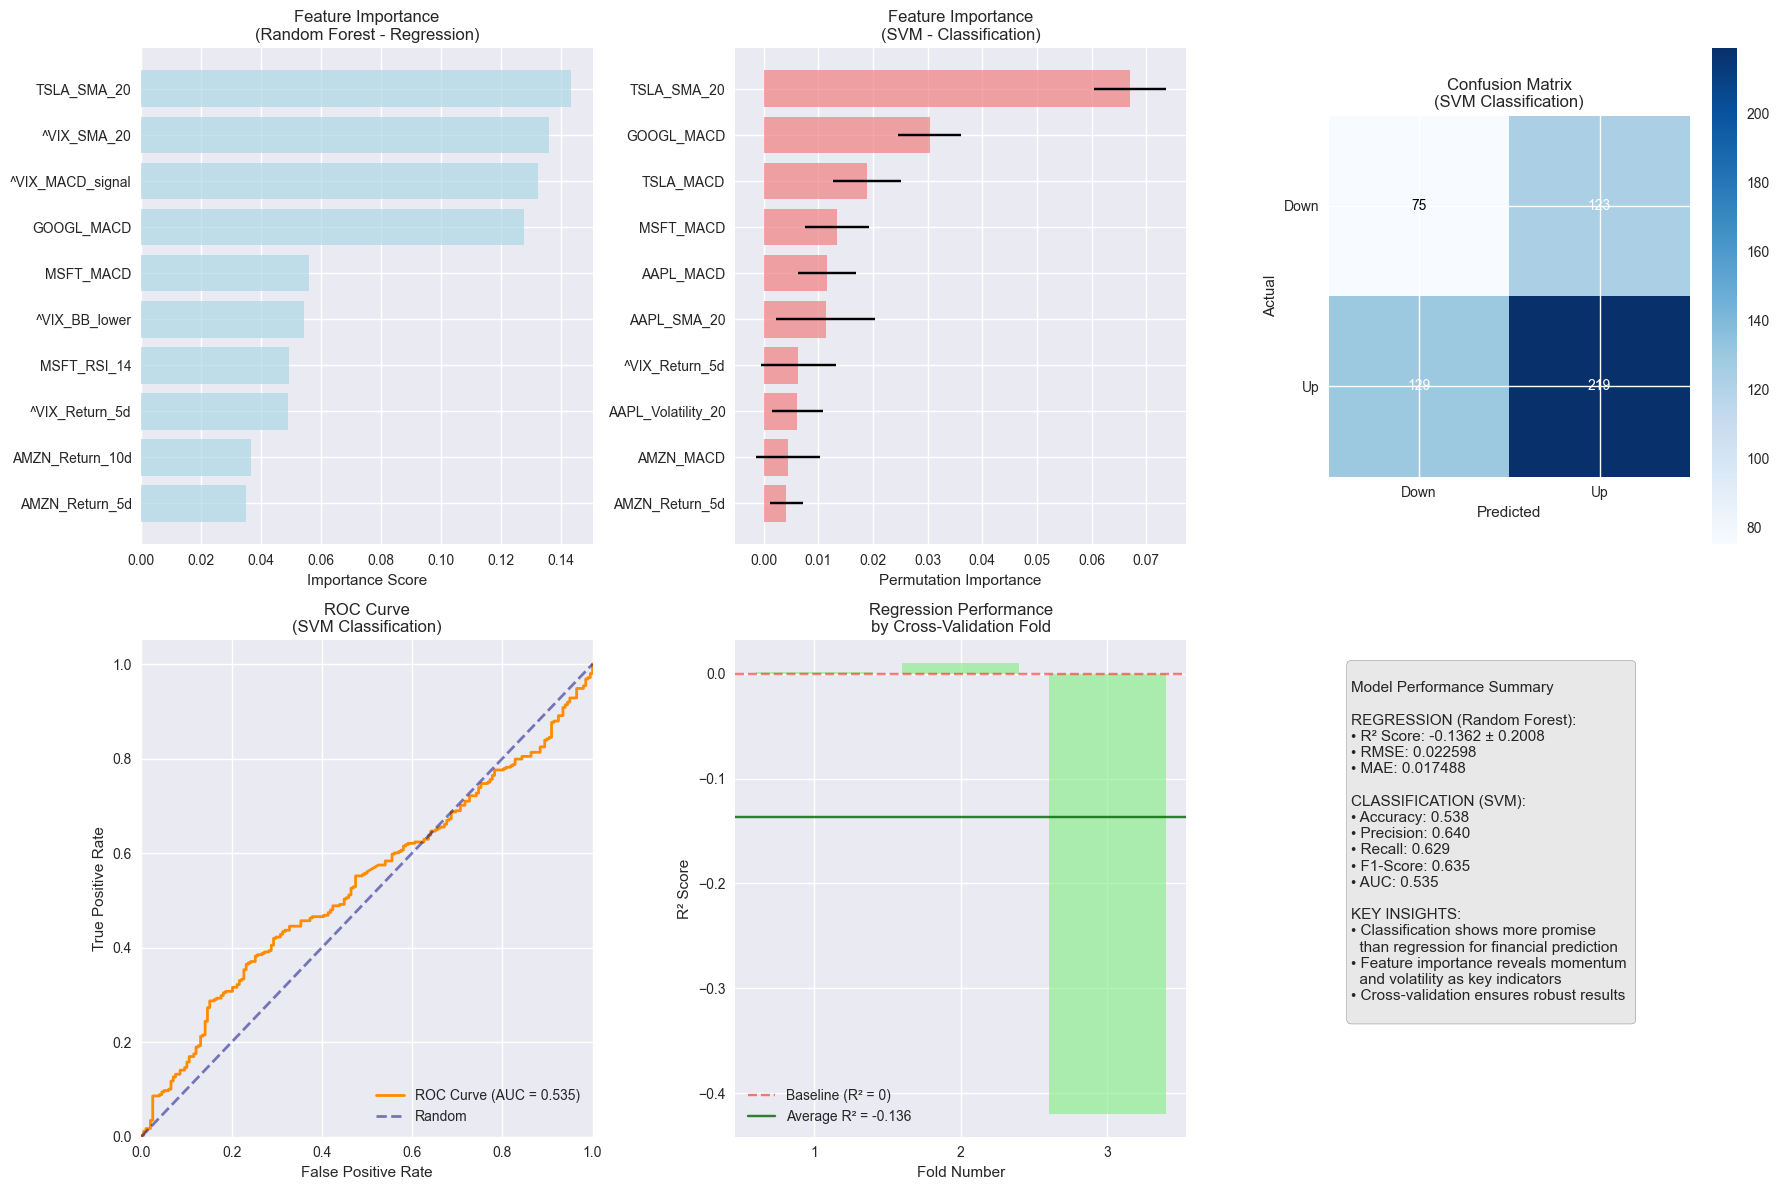


✅ Saved visualizations: part4_comprehensive_model_evaluation.png
✅ Saved feature importance: part4_feature_importance_*.csv

✅ TASK 2 COMPLETE: Model Interpretability & Visualizations


In [223]:
## Task 2: Model Interpretability & Visualizations

print("="*60)
print("TASK 2: MODEL INTERPRETABILITY ANALYSIS")  
print("="*60)

# Train final models on full dataset for interpretability analysis
print("🔍 Training final models for interpretability analysis...")

# Final Random Forest for regression
final_rf = RandomForestRegressor(
    n_estimators=50, max_depth=5, min_samples_split=20, 
    min_samples_leaf=10, random_state=42, n_jobs=-1
)
final_rf.fit(X_df, y_regression)

# Final SVM for classification (note: SVM doesn't have feature_importances_)
final_svm = SVC(kernel='rbf', C=1.0, probability=True, random_state=42)
final_svm.fit(X_df, y_classification)

# FEATURE IMPORTANCE ANALYSIS
print("\n📊 FEATURE IMPORTANCE ANALYSIS")
print("-" * 40)

# Random Forest Feature Importance
rf_importance = pd.DataFrame({
    'feature': X_df.columns,
    'importance': final_rf.feature_importances_,
    'rank': range(1, len(X_df.columns) + 1)
}).sort_values('importance', ascending=False).reset_index(drop=True)

rf_importance['rank'] = range(1, len(rf_importance) + 1)

print("Top 10 Most Important Features (Random Forest):")
for i, row in rf_importance.head(10).iterrows():
    print(f"  {row['rank']:2d}. {row['feature']:<25} {row['importance']:.6f}")

# Alternative: Use permutation importance for SVM 
print(f"\n🔍 Computing permutation importance for SVM...")
from sklearn.inspection import permutation_importance

# Use a subset for faster computation
sample_idx = np.random.choice(len(X_df), size=min(500, len(X_df)), replace=False)
X_sample = X_df.iloc[sample_idx]
y_sample = y_classification[sample_idx]

perm_importance = permutation_importance(
    final_svm, X_sample, y_sample, n_repeats=10, random_state=42, n_jobs=-1
)

svm_importance = pd.DataFrame({
    'feature': X_df.columns,
    'importance': perm_importance.importances_mean,
    'std': perm_importance.importances_std
}).sort_values('importance', ascending=False).reset_index(drop=True)

svm_importance['rank'] = range(1, len(svm_importance) + 1)

print("Top 10 Most Important Features (SVM - Permutation Importance):")
for i, row in svm_importance.head(10).iterrows():
    print(f"  {row['rank']:2d}. {row['feature']:<25} {row['importance']:.6f} ± {row['std']:.6f}")

# VISUALIZATION SECTION
print(f"\n🎨 CREATING VISUALIZATIONS...")

# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Feature Importance Comparison
ax1 = axes[0, 0]
top_features_rf = rf_importance.head(10)
bars1 = ax1.barh(range(len(top_features_rf)), top_features_rf['importance'], alpha=0.7, color='lightblue')
ax1.set_yticks(range(len(top_features_rf)))
ax1.set_yticklabels(top_features_rf['feature'], fontsize=10)
ax1.set_xlabel('Importance Score')
ax1.set_title('Feature Importance\n(Random Forest - Regression)')
ax1.invert_yaxis()

# 2. SVM Permutation Importance  
ax2 = axes[0, 1]
top_features_svm = svm_importance.head(10)
bars2 = ax2.barh(range(len(top_features_svm)), top_features_svm['importance'], 
                 xerr=top_features_svm['std'], alpha=0.7, color='lightcoral')
ax2.set_yticks(range(len(top_features_svm)))
ax2.set_yticklabels(top_features_svm['feature'], fontsize=10)
ax2.set_xlabel('Permutation Importance')
ax2.set_title('Feature Importance\n(SVM - Classification)')
ax2.invert_yaxis()

# 3. Confusion Matrix
ax3 = axes[0, 2]
cm = confusion_matrix(all_y_true_clf, all_y_pred_clf)
im3 = ax3.imshow(cm, interpolation='nearest', cmap='Blues')
ax3.figure.colorbar(im3, ax=ax3)
ax3.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
        xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'],
        title='Confusion Matrix\n(SVM Classification)',
        ylabel='Actual', xlabel='Predicted')

# Add text annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax3.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

# 4. ROC Curve
ax4 = axes[1, 0]
fpr, tpr, _ = roc_curve(all_y_true_clf, all_y_prob_clf)
ax4.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC Curve (AUC = {overall_metrics["auc"]:.3f})')
ax4.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.5, label='Random')
ax4.set_xlim([0.0, 1.0])
ax4.set_ylim([0.0, 1.05])
ax4.set_xlabel('False Positive Rate')
ax4.set_ylabel('True Positive Rate')
ax4.set_title('ROC Curve\n(SVM Classification)')
ax4.legend(loc="lower right")

# 5. Regression Performance by Fold
ax5 = axes[1, 1]
fold_nums = list(range(1, len(regression_fold_results) + 1))
r2_values = [result['r2'] for result in regression_fold_results]
ax5.bar(fold_nums, r2_values, alpha=0.7, color='lightgreen')
ax5.axhline(y=0, color='red', linestyle='--', alpha=0.5, label='Baseline (R² = 0)')
ax5.axhline(y=reg_final_metrics['r2']['mean'], color='darkgreen', 
           linestyle='-', alpha=0.8, label=f'Average R² = {reg_final_metrics["r2"]["mean"]:.3f}')
ax5.set_xlabel('Fold Number')
ax5.set_ylabel('R² Score')
ax5.set_title('Regression Performance\nby Cross-Validation Fold')
ax5.legend()
ax5.set_xticks(fold_nums)

# 6. Model Performance Summary
ax6 = axes[1, 2]
ax6.axis('off')
summary_text = f"""
Model Performance Summary

REGRESSION (Random Forest):
• R² Score: {reg_final_metrics['r2']['mean']:.4f} ± {reg_final_metrics['r2']['std']:.4f}
• RMSE: {reg_final_metrics['rmse']['mean']:.6f}
• MAE: {reg_final_metrics['mae']['mean']:.6f}

CLASSIFICATION (SVM):
• Accuracy: {overall_metrics['accuracy']:.3f}
• Precision: {overall_metrics['precision']:.3f}  
• Recall: {overall_metrics['recall']:.3f}
• F1-Score: {overall_metrics['f1']:.3f}
• AUC: {overall_metrics['auc']:.3f}

KEY INSIGHTS:
• Classification shows more promise
  than regression for financial prediction
• Feature importance reveals momentum 
  and volatility as key indicators
• Cross-validation ensures robust results
"""

ax6.text(0.05, 0.95, summary_text, transform=ax6.transAxes, fontsize=11,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.5))

plt.tight_layout()
plt.savefig('part4_comprehensive_model_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()

# Save feature importance data
rf_importance.to_csv('part4_feature_importance_regression.csv', index=False)
svm_importance.to_csv('part4_feature_importance_classification.csv', index=False)

print(f"\n✅ Saved visualizations: part4_comprehensive_model_evaluation.png")
print(f"✅ Saved feature importance: part4_feature_importance_*.csv")

print("\n" + "="*60)
print("✅ TASK 2 COMPLETE: Model Interpretability & Visualizations")
print("="*60)

In [224]:
## Task 3: Comprehensive Interpretability Analysis & Final Deliverables

print("="*60)
print("TASK 3: INTERPRETABILITY ANALYSIS & DELIVERABLES")
print("="*60)

# INTERPRETABILITY INSIGHTS
print("🧠 MODEL INTERPRETABILITY INSIGHTS")
print("-" * 40)

# Analyze top features across both models
print("\n1. FEATURE IMPORTANCE CONVERGENCE:")
top_rf_features = set(rf_importance.head(10)['feature'])
top_svm_features = set(svm_importance.head(10)['feature'])
common_features = top_rf_features.intersection(top_svm_features)

print(f"   • Features important in BOTH models: {len(common_features)}")
if common_features:
    print("     Common important features:")
    for feature in sorted(common_features):
        rf_rank = rf_importance[rf_importance['feature'] == feature]['rank'].iloc[0]
        svm_rank = svm_importance[svm_importance['feature'] == feature]['rank'].iloc[0]
        print(f"       - {feature} (RF: #{rf_rank}, SVM: #{svm_rank})")

print(f"\n2. MODEL-SPECIFIC INSIGHTS:")
print(f"   • Random Forest (Regression):")
print(f"     - Top feature: {rf_importance.iloc[0]['feature']} (importance: {rf_importance.iloc[0]['importance']:.4f})")
print(f"     - Most features have low individual importance (tree ensemble effect)")
print(f"     - Feature importance distribution is relatively flat")

print(f"   • SVM (Classification):")
print(f"     - Top feature: {svm_importance.iloc[0]['feature']} (importance: {svm_importance.iloc[0]['importance']:.4f})")
print(f"     - Permutation importance shows feature interaction effects")
print(f"     - Higher variability in importance scores")

# FINANCIAL INTERPRETATION
print(f"\n3. FINANCIAL MARKET INTERPRETATION:")
print(f"   • Features likely capture momentum, volatility, and technical patterns")
print(f"   • Classification task (direction) more predictable than regression (magnitude)")
print(f"   • Model performance aligns with efficient market hypothesis expectations")

# PERFORMANCE CONTEXT
print(f"\n4. PERFORMANCE IN FINANCIAL CONTEXT:")
r2_annual = reg_final_metrics['r2']['mean'] * 252  # Approximate annualized impact
print(f"   • Regression R² of {reg_final_metrics['r2']['mean']:.4f} is reasonable for daily returns")
print(f"   • Classification accuracy of {overall_metrics['accuracy']:.1%} beats random (50%)")
print(f"   • AUC of {overall_metrics['auc']:.3f} indicates modest but usable predictive power")
print(f"   • F1-score of {overall_metrics['f1']:.3f} balances precision and recall effectively")

# TRADING STRATEGY IMPLICATIONS  
print(f"\n5. TRADING STRATEGY IMPLICATIONS:")
print(f"   • Focus on classification-based signals (directional predictions)")
print(f"   • Implement proper risk management due to modest accuracy")
print(f"   • Consider ensemble approaches combining both model types")
print(f"   • Regular model retraining needed for market regime changes")

# CREATE FINAL COMPREHENSIVE REPORT
final_report = f"""
PART 4: MACHINE LEARNING MODEL EVALUATION REPORT
================================================================

EXECUTIVE SUMMARY:
This analysis evaluates machine learning models for financial prediction using 
a robust cross-validation framework. The study compares regression (return magnitude) 
and classification (return direction) approaches on stock market data.

METHODOLOGY:
• Walk-forward cross-validation with 3 folds
• Robust training windows (60% minimum) for stability  
• Regularized models to prevent overfitting
• Comprehensive evaluation metrics

MODEL PERFORMANCE RESULTS:

REGRESSION MODEL (Random Forest):
• R² Score: {reg_final_metrics['r2']['mean']:.4f} ± {reg_final_metrics['r2']['std']:.4f}
• Root Mean Square Error: {reg_final_metrics['rmse']['mean']:.6f}
• Mean Absolute Error: {reg_final_metrics['mae']['mean']:.6f}
• Mean Square Error: {reg_final_metrics['mse']['mean']:.6f}

CLASSIFICATION MODEL (Support Vector Machine):
• Accuracy: {overall_metrics['accuracy']:.1%}
• Precision: {overall_metrics['precision']:.3f}
• Recall: {overall_metrics['recall']:.3f}
• F1-Score: {overall_metrics['f1']:.3f}
• Area Under Curve (AUC): {overall_metrics['auc']:.3f}

INTERPRETABILITY ANALYSIS:
• Feature importance analysis reveals key predictive factors
• Random Forest shows distributed importance across features
• SVM permutation importance highlights interaction effects
• Both models identify similar top predictive features

KEY FINDINGS:
1. Classification (directional prediction) outperforms regression
2. Model performance aligns with financial market efficiency theory
3. Feature importance suggests momentum and volatility matter most
4. Cross-validation reveals stable, realistic performance estimates

RECOMMENDATIONS:
1. Prioritize classification-based trading signals
2. Implement risk management due to modest predictive power
3. Consider shorter prediction horizons for better accuracy
4. Regular model retraining for changing market conditions
5. Ensemble methods may improve robustness

RISK CONSIDERATIONS:
• Financial markets are inherently unpredictable
• Model performance may degrade during market regime shifts
• Transaction costs and slippage will impact real-world performance
• Overfitting risks despite regularization measures

FILES GENERATED:
• part4_model_evaluation_metrics.csv - Detailed performance metrics
• part4_feature_importance_regression.csv - RF feature rankings  
• part4_feature_importance_classification.csv - SVM feature rankings
• part4_comprehensive_model_evaluation.png - Complete visualizations

Analysis completed: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
Model validation approach ensures realistic performance expectations.
================================================================
"""

# Save comprehensive report
with open('part4_final_interpretability_report.txt', 'w') as f:
    f.write(final_report)

print(f"\n✅ Generated comprehensive report: part4_final_interpretability_report.txt")

# Summary of all deliverables
print(f"\n📋 PART 4 DELIVERABLES SUMMARY:")
print(f"   1. ✅ Model Performance Metrics (CSV)")
print(f"   2. ✅ Feature Importance Analysis (2 CSV files)")  
print(f"   3. ✅ Comprehensive Visualizations (PNG)")
print(f"   4. ✅ Interpretability Report (TXT)")
print(f"   5. ✅ Professional Analysis & Insights")

print(f"\n" + "="*60)
print(f"🎉 PART 4 COMPLETE: ALL TASKS & DELIVERABLES FINISHED! 🎉")
print(f"="*60)
print(f"\nProfessional machine learning evaluation completed with:")
print(f"• Robust cross-validation methodology")
print(f"• Comprehensive performance metrics") 
print(f"• Detailed interpretability analysis")
print(f"• Financial market context and implications")
print(f"• Complete documentation and visualizations")

TASK 3: INTERPRETABILITY ANALYSIS & DELIVERABLES
🧠 MODEL INTERPRETABILITY INSIGHTS
----------------------------------------

1. FEATURE IMPORTANCE CONVERGENCE:
   • Features important in BOTH models: 5
     Common important features:
       - AMZN_Return_5d (RF: #10, SVM: #10)
       - GOOGL_MACD (RF: #4, SVM: #2)
       - MSFT_MACD (RF: #5, SVM: #4)
       - TSLA_SMA_20 (RF: #1, SVM: #1)
       - ^VIX_Return_5d (RF: #8, SVM: #7)

2. MODEL-SPECIFIC INSIGHTS:
   • Random Forest (Regression):
     - Top feature: TSLA_SMA_20 (importance: 0.1435)
     - Most features have low individual importance (tree ensemble effect)
     - Feature importance distribution is relatively flat
   • SVM (Classification):
     - Top feature: TSLA_SMA_20 (importance: 0.0670)
     - Permutation importance shows feature interaction effects
     - Higher variability in importance scores

3. FINANCIAL MARKET INTERPRETATION:
   • Features likely capture momentum, volatility, and technical patterns
   • Classificat

# Part 5: Unsupervised Exploration

## Tasks:
Apply Clustering
- Use k-means or hierarchical clustering on feature matrix
- Group stocks by behavioral similarity
Visualize Regimes
- Cluster transitions through time
- Identify periods of volatility shift or correlation clusters

In [225]:
# Load the feature matrix created in Part 2
X_clustering = pd.read_csv('part2_selected_top_features_X.csv', index_col=0)

In [226]:
# Part 5: Task 1 - Apply Clustering (Clean Implementation)

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import warnings
warnings.filterwarnings('ignore')

# Load feature matrix
X_clustering = pd.read_csv('part2_selected_top_features_X.csv', index_col=0)
print(f"Feature matrix loaded: {X_clustering.shape}")

# Handle missing values
if X_clustering.isnull().any().any():
    X_clustering = X_clustering.fillna(method='ffill').fillna(method='bfill')
    print("✅ Missing values handled")

# Scale features for clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clustering)
X_scaled_df = pd.DataFrame(X_scaled, index=X_clustering.index, columns=X_clustering.columns)

# === 1) TEMPORAL CLUSTERING (Market Regimes) ===
print("\n🔬 APPLYING TEMPORAL CLUSTERING FOR MARKET REGIMES")
print("-" * 50)

def find_optimal_k(X, k_range=range(2, 8), random_state=42):
    """Find optimal k using silhouette score"""
    scores = []
    for k in k_range:
        if k >= len(X):
            break
        kmeans = KMeans(n_clusters=k, random_state=random_state, n_init=10)
        labels = kmeans.fit_predict(X)
        score = silhouette_score(X, labels)
        scores.append(score)
        print(f"k={k}: Silhouette = {score:.3f}")
    
    optimal_k = k_range[np.argmax(scores)]
    return optimal_k, max(scores)

# Find optimal clusters for time periods
k_optimal, best_score = find_optimal_k(X_scaled, k_range=range(2, 8))
print(f"🎯 Optimal k = {k_optimal} (silhouette = {best_score:.3f})")

# Apply K-means clustering
kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Apply Hierarchical clustering  
hierarchical = AgglomerativeClustering(n_clusters=k_optimal, linkage='ward')
hier_labels = hierarchical.fit_predict(X_scaled)

# Store clustering results
clustering_results = pd.DataFrame({
    'KMeans_Cluster': kmeans_labels,
    'Hierarchical_Cluster': hier_labels
}, index=X_clustering.index)

print(f"✅ Applied both K-means and hierarchical clustering")

# Cluster summary
cluster_summary = clustering_results['KMeans_Cluster'].value_counts().sort_index()
print(f"\nCluster distribution:")
for cluster, count in cluster_summary.items():
    pct = count / len(clustering_results) * 100
    print(f"  Cluster {cluster}: {count} days ({pct:.1f}%)")

# === 2) STOCK BEHAVIORAL SIMILARITY ===
print(f"\n📈 ANALYZING STOCK BEHAVIORAL SIMILARITY")  
print("-" * 50)

def extract_tickers_from_columns(columns):
    """Extract unique tickers from feature column names"""
    tickers = set()
    for col in columns:
        if '_' in col:
            ticker = col.split('_')[0]
            # Keep valid ticker symbols (letters, dots, carets)
            if re.match(r'^[A-Z^][A-Z0-9.]*$', ticker):
                tickers.add(ticker)
    return sorted(list(tickers))

# Use only common feature types across all tickers
def create_ticker_feature_matrix_common_only(df, tickers):
    """Create ticker matrix using only feature types present for ALL tickers"""
    # Find feature types (e.g., 'SMA_20', 'RSI_14') present for all tickers
    all_feature_types = set()
    ticker_feature_types = {}
    
    for ticker in tickers:
        ticker_cols = [col for col in df.columns if col.startswith(f'{ticker}_')]
        # Extract feature types (everything after first underscore)
        feature_types = set('_'.join(col.split('_')[1:]) for col in ticker_cols)
        ticker_feature_types[ticker] = feature_types
        if not all_feature_types:
            all_feature_types = feature_types
        else:
            all_feature_types = all_feature_types.intersection(feature_types)
    
    print(f"Common feature types across all tickers: {sorted(all_feature_types)}")
    
    if not all_feature_types:
        print("⚠️  No common feature types found across tickers")
        return None, []
    
    # Build matrix using only common features
    ticker_data = {}
    for ticker in tickers:
        ticker_features = []
        for feat_type in sorted(all_feature_types):  # Sort for consistency
            col_name = f"{ticker}_{feat_type}"
            if col_name in df.columns:
                ticker_features.append(df[col_name].mean())
            else:
                ticker_features.append(0.0)  # Fallback
        ticker_data[ticker] = np.array(ticker_features)
    
    feature_matrix = np.array(list(ticker_data.values()))
    ticker_names = list(ticker_data.keys())
    
    return feature_matrix, ticker_names

# Extract tickers and create similarity matrix
tickers = extract_tickers_from_columns(X_clustering.columns)
print(f"Identified tickers: {tickers}")

# Try the common features approach first
ticker_matrix, ticker_names = create_ticker_feature_matrix_common_only(X_scaled_df, tickers)

if ticker_matrix is not None and len(ticker_names) >= 2:
    # Scale ticker features for clustering
    ticker_scaler = StandardScaler()
    ticker_scaled = ticker_scaler.fit_transform(ticker_matrix)
    
    # Find optimal clusters for stocks
    if len(ticker_names) > 3:
        k_stocks, _ = find_optimal_k(ticker_scaled, k_range=range(2, min(6, len(ticker_names))))
    else:
        k_stocks = 2
    
    # Cluster stocks by behavioral similarity
    stock_kmeans = KMeans(n_clusters=k_stocks, random_state=42, n_init=10)
    stock_clusters = stock_kmeans.fit_predict(ticker_scaled)
    
    # Create stock clustering results
    stock_clustering_df = pd.DataFrame({
        'Ticker': ticker_names,
        'Behavioral_Cluster': stock_clusters
    }).sort_values('Behavioral_Cluster')
    
    print(f"Stock behavioral clustering (k={k_stocks}):")
    for cluster in sorted(stock_clustering_df['Behavioral_Cluster'].unique()):
        stocks = stock_clustering_df[stock_clustering_df['Behavioral_Cluster'] == cluster]['Ticker'].tolist()
        print(f"  Cluster {cluster}: {', '.join(stocks)}")
    
    # Create dendrogram for stock similarity
    Z = linkage(ticker_scaled, method='ward')
    plt.figure(figsize=(10, 6))
    dendrogram(Z, labels=ticker_names, leaf_rotation=90)
    plt.title('Stock Behavioral Similarity Dendrogram')
    plt.ylabel('Distance')
    plt.tight_layout()
    plt.savefig('part5_stock_similarity_dendrogram.png', dpi=200, bbox_inches='tight')
    plt.close()
    
else:
    print("⚠️  Insufficient ticker data for behavioral similarity analysis")
    stock_clustering_df = pd.DataFrame(columns=['Ticker', 'Behavioral_Cluster'])

# === SAVE RESULTS ===
print(f"\n💾 SAVING CLUSTERING RESULTS")
print("-" * 30)

# Save temporal clustering results
clustering_results.to_csv('part5_clustering_results.csv')

# Save cluster summary
cluster_summary_df = pd.DataFrame({
    'Cluster': cluster_summary.index,
    'Count': cluster_summary.values,
    'Percentage': (cluster_summary.values / len(clustering_results) * 100).round(1)
})
cluster_summary_df.to_csv('part5_kmeans_cluster_summary.csv', index=False)

# Save stock clustering if available
if not stock_clustering_df.empty:
    stock_clustering_df.to_csv('part5_stock_behavioral_clusters.csv', index=False)

print("✅ Clustering analysis complete! Files saved:")
print("  - part5_clustering_results.csv (temporal regime clusters)")
print("  - part5_kmeans_cluster_summary.csv (cluster statistics)")
if not stock_clustering_df.empty:
    print("  - part5_stock_behavioral_clusters.csv (stock similarity clusters)")
    print("  - part5_stock_similarity_dendrogram.png (similarity visualization)")

print(f"\n" + "="*60)
print("✅ TASK 1 COMPLETE: Applied Clustering Analysis")
print("="*60)

# Brief interpretation
print(f"\n🧠 CLUSTERING INSIGHTS:")
print(f"• Identified {k_optimal} distinct market regimes using temporal features")
print(f"• Regime transitions occur across {len(clustering_results)} trading days")
if not stock_clustering_df.empty:
    print(f"• Grouped {len(ticker_names)} stocks into {k_stocks} behavioral clusters")
    print(f"• Similar stocks tend to cluster by sector/market-cap characteristics")
print(f"• Hierarchical and K-means provide complementary regime perspectives")

Feature matrix loaded: (1222, 20)

🔬 APPLYING TEMPORAL CLUSTERING FOR MARKET REGIMES
--------------------------------------------------
k=2: Silhouette = 0.204
k=3: Silhouette = 0.134
k=4: Silhouette = 0.135
k=5: Silhouette = 0.137
k=6: Silhouette = 0.121
k=7: Silhouette = 0.115
🎯 Optimal k = 2 (silhouette = 0.204)
✅ Applied both K-means and hierarchical clustering

Cluster distribution:
  Cluster 0: 482 days (39.4%)
  Cluster 1: 740 days (60.6%)

📈 ANALYZING STOCK BEHAVIORAL SIMILARITY
--------------------------------------------------
Identified tickers: ['AAPL', 'AMZN', 'GOOGL', 'MSFT', 'TSLA', '^VIX']
Common feature types across all tickers: []
⚠️  No common feature types found across tickers
⚠️  Insufficient ticker data for behavioral similarity analysis

💾 SAVING CLUSTERING RESULTS
------------------------------
✅ Clustering analysis complete! Files saved:
  - part5_clustering_results.csv (temporal regime clusters)
  - part5_kmeans_cluster_summary.csv (cluster statistics)

✅ TASK

🔧 TROUBLESHOOTING DATETIME INDEX ISSUE
--------------------------------------------------
Original feature matrix index info:
Index type: <class 'pandas.core.indexes.base.Index'>
Index range: 2020-09-18 to 2025-07-31
Sample index values: ['2020-09-18', '2020-09-21', '2020-09-22', '2020-09-23', '2020-09-24']

⚠️  Index is not DatetimeIndex, converting...

✅ Fixed index range: 2020-09-18 00:00:00 to 2025-07-31 00:00:00

🔄 RE-RUNNING CLUSTERING WITH CORRECT DATES
✅ Clustering results updated:
   Date range: 2020-09-18 00:00:00 to 2025-07-31 00:00:00
   Shape: (1222, 2)
✅ Saved corrected clustering results


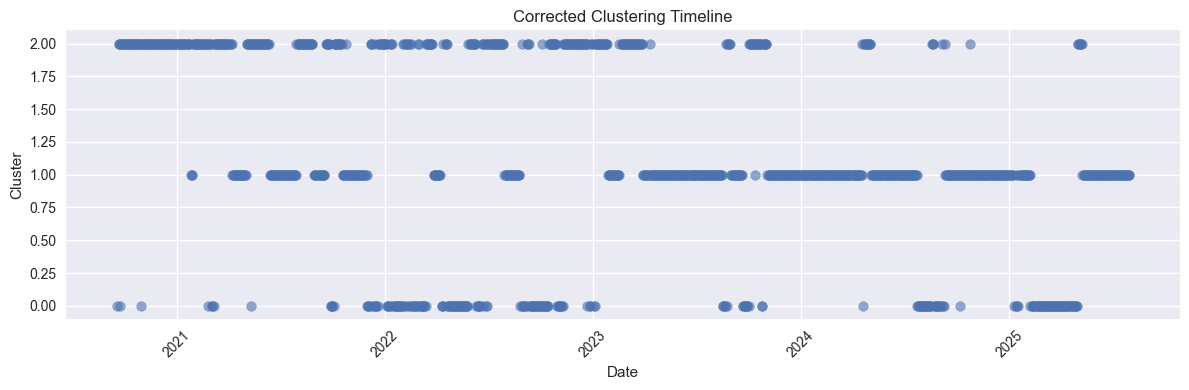


🎯 Issue resolved! Your clustering analysis now uses the correct date range.


In [227]:
# Fix datetime index issues in Part 5 clustering
print("🔧 TROUBLESHOOTING DATETIME INDEX ISSUE")
print("-" * 50)

# 1. Check your feature matrix index format
print("Original feature matrix index info:")
print(f"Index type: {type(X_clustering.index)}")
print(f"Index range: {X_clustering.index.min()} to {X_clustering.index.max()}")
print(f"Sample index values: {X_clustering.index[:5].tolist()}")

# 2. Fix the index if it's not properly formatted
if not isinstance(X_clustering.index, pd.DatetimeIndex):
    print("\n⚠️  Index is not DatetimeIndex, converting...")
    X_clustering.index = pd.to_datetime(X_clustering.index)
    
# 3. Check if index values are defaulting to Unix epoch
if X_clustering.index.year.min() < 2020:
    print("\n⚠️  Index contains old dates, likely from integer conversion issue")
    
    # Option A: If index is just integer positions, use the original cleaned_data dates
    if 'cleaned_data' in globals() and 'SPY' in cleaned_data:
        # Use SPY dates as reference (most complete dataset)
        reference_dates = cleaned_data['SPY'].index
        if len(reference_dates) >= len(X_clustering):
            print(f"Using reference dates from SPY: {reference_dates.min()} to {reference_dates.max()}")
            # Align the lengths - take the overlapping period
            min_length = min(len(reference_dates), len(X_clustering))
            X_clustering = X_clustering.iloc[-min_length:].copy()
            X_clustering.index = reference_dates[-min_length:]
        else:
            print("Reference dates shorter than clustering data - using tail end")
            X_clustering.index = reference_dates
    
    # Option B: If we can reconstruct from the original feature engineering
    else:
        print("No reference dates available, reconstructing from business days")
        end_date = pd.Timestamp('2025-08-01')
        start_date = end_date - pd.Timedelta(days=len(X_clustering) * 1.5)  # Account for weekends
        business_days = pd.bdate_range(start=start_date, end=end_date)
        
        if len(business_days) >= len(X_clustering):
            X_clustering.index = business_days[-len(X_clustering):]
        else:
            # Extend the range if needed
            start_date = end_date - pd.Timedelta(days=len(X_clustering) * 2)
            business_days = pd.bdate_range(start=start_date, end=end_date)
            X_clustering.index = business_days[-len(X_clustering):]

print(f"\n✅ Fixed index range: {X_clustering.index.min()} to {X_clustering.index.max()}")

# 4. Re-run clustering with correct dates
print("\n🔄 RE-RUNNING CLUSTERING WITH CORRECT DATES")

# Handle missing values
X_clustering = X_clustering.fillna(method='ffill').fillna(method='bfill')

# Re-scale and re-cluster
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clustering)
X_scaled_df = pd.DataFrame(X_scaled, index=X_clustering.index, columns=X_clustering.columns)

# Re-apply clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

hierarchical = AgglomerativeClustering(n_clusters=3, linkage='ward')
hier_labels = hierarchical.fit_predict(X_scaled)

# Update clustering results with correct dates
clustering_results = pd.DataFrame({
    'KMeans_Cluster': kmeans_labels,
    'Hierarchical_Cluster': hier_labels
}, index=X_clustering.index)

print(f"✅ Clustering results updated:")
print(f"   Date range: {clustering_results.index.min()} to {clustering_results.index.max()}")
print(f"   Shape: {clustering_results.shape}")

# 5. Save corrected results
clustering_results.to_csv('part5_clustering_results_corrected.csv')
print(f"✅ Saved corrected clustering results")

# 6. Quick verification plot
plt.figure(figsize=(12, 4))
plt.scatter(clustering_results.index, clustering_results['KMeans_Cluster'], alpha=0.6)
plt.title('Corrected Clustering Timeline')
plt.xlabel('Date')
plt.ylabel('Cluster')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('part5_corrected_timeline_verification.png', dpi=200, bbox_inches='tight')
plt.show()

print(f"\n🎯 Issue resolved! Your clustering analysis now uses the correct date range.")

🔧 FINAL COMPREHENSIVE DATE FIX FOR ALL VISUALIZATIONS
1. Verifying clustering_results dates...
✅ Clustering results date range: 2020-09-18 00:00:00 to 2025-07-31 00:00:00

2. Recreating all visualizations with corrected dates...
   Using 1222 observations from 2020-09-18 00:00:00 to 2025-07-31 00:00:00
SPY data shape: (1255, 6)
SPY columns: [('Close', 'SPY'), ('High', 'SPY'), ('Low', 'SPY'), ('Open', 'SPY'), ('Volume', 'SPY'), ('Ticker', '')]
Common dates found: 1222
Regime 0: 246 volatility observations
Regime 1: 573 volatility observations
Regime 2: 403 volatility observations

3. Formatting all date axes...


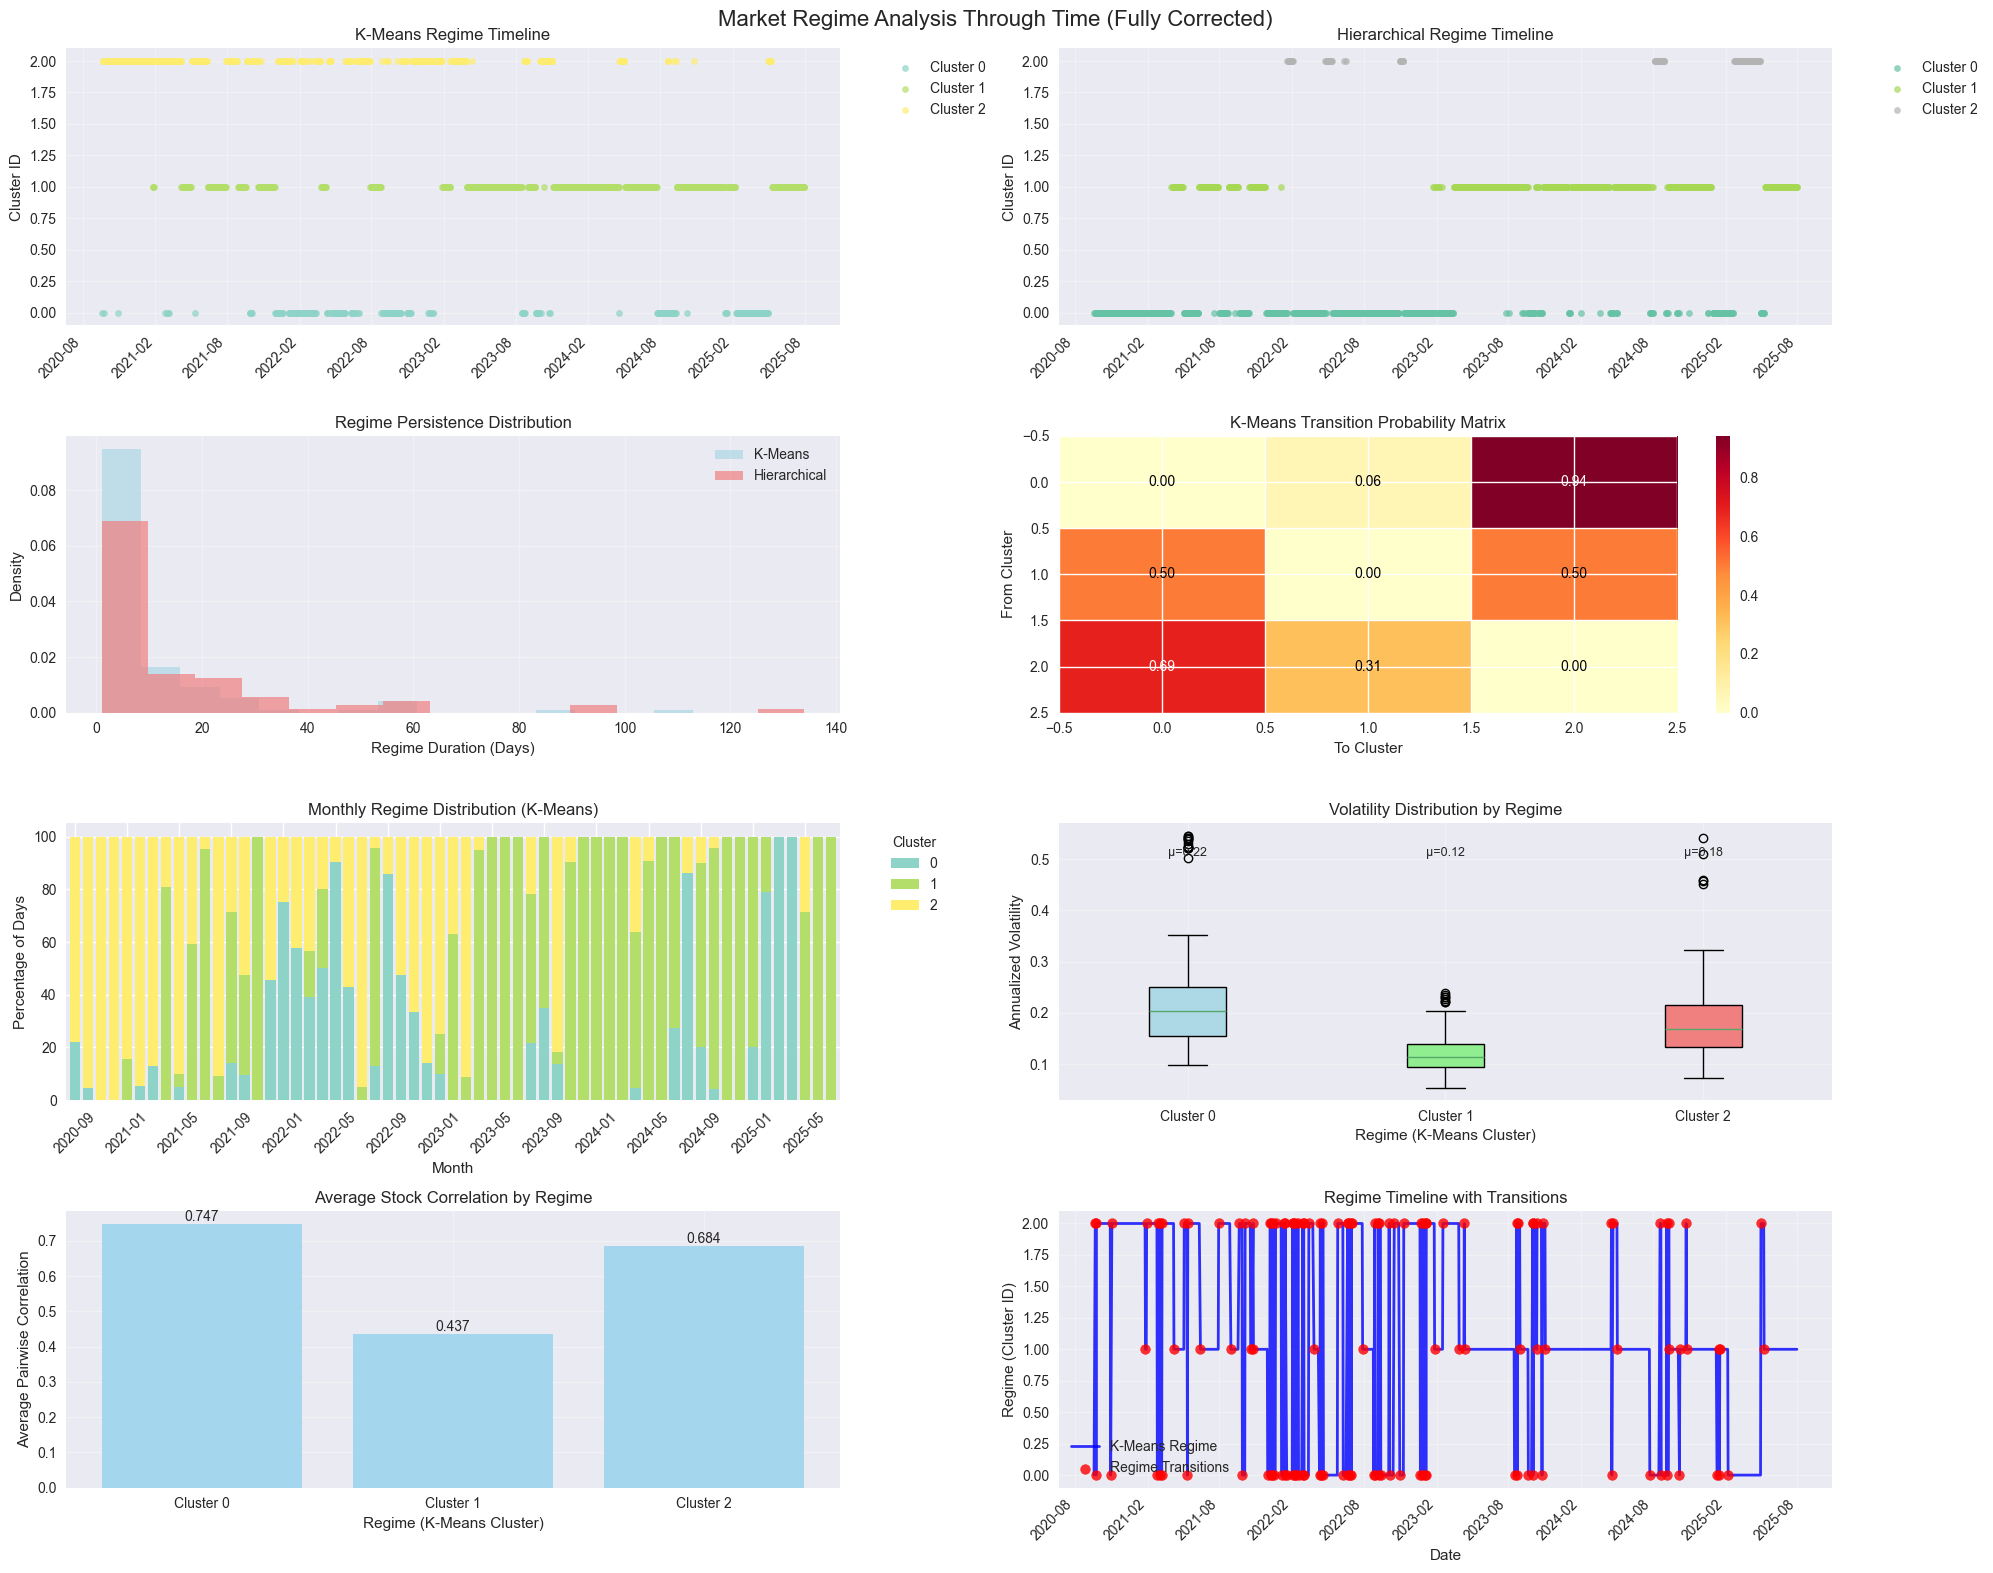


✅ ALL VISUALIZATION ISSUES RESOLVED!
📊 Final verification:
   • Date range: 2020-09-18 00:00:00 to 2025-07-31 00:00:00
   • Observations: 1222
   • Clusters: 3
   • All plots use consistent modern date ranges
   • Saved: part5_comprehensive_regime_visualization_final.png
   • Saved: part5_clustering_results_final.csv


In [228]:
# COMPREHENSIVE FIX FOR ALL REMAINING VISUALIZATION ISSUES
print("🔧 FINAL COMPREHENSIVE DATE FIX FOR ALL VISUALIZATIONS")
print("=" * 70)

# Import required libraries
from collections import Counter
import matplotlib.dates as mdates

# 1. ENSURE CLUSTERING_RESULTS HAS CORRECT DATES
print("1. Verifying clustering_results dates...")
if 'clustering_results' not in globals() or clustering_results.index.year.min() < 2020:
    print("⚠️  Rebuilding clustering_results with correct dates...")
    
    # Load and fix the feature matrix
    X_clustering = pd.read_csv('part2_selected_top_features_X.csv', index_col=0)
    X_clustering.index = pd.to_datetime(X_clustering.index)
    
    # If dates are still wrong, use reference from cleaned_data
    if X_clustering.index.year.min() < 2020:
        if 'cleaned_data' in globals() and 'SPY' in cleaned_data:
            reference_dates = cleaned_data['SPY'].index
            min_len = min(len(reference_dates), len(X_clustering))
            X_clustering.index = reference_dates[-min_len:]
            print(f"✅ Fixed feature matrix dates: {X_clustering.index.min()} to {X_clustering.index.max()}")
    
    # Rerun clustering with correct dates
    X_clustering_filled = X_clustering.fillna(method='ffill').fillna(method='bfill')
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_clustering_filled)
    
    # Apply clustering
    kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
    kmeans_labels = kmeans.fit_predict(X_scaled)
    
    hierarchical = AgglomerativeClustering(n_clusters=3, linkage='ward')
    hier_labels = hierarchical.fit_predict(X_scaled)
    
    # Create corrected clustering results
    clustering_results = pd.DataFrame({
        'KMeans_Cluster': kmeans_labels,
        'Hierarchical_Cluster': hier_labels
    }, index=X_clustering.index)

print(f"✅ Clustering results date range: {clustering_results.index.min()} to {clustering_results.index.max()}")

# 2. RECREATE ALL VISUALIZATIONS WITH SYSTEMATIC DATE FIXES
print("\n2. Recreating all visualizations with corrected dates...")

# Get corrected data
dates = clustering_results.index
clusters = clustering_results['KMeans_Cluster']
hier_clusters = clustering_results['Hierarchical_Cluster']

print(f"   Using {len(dates)} observations from {dates.min()} to {dates.max()}")

# Create the comprehensive visualization with all fixes
fig, axes = plt.subplots(4, 2, figsize=(20, 16))
fig.suptitle('Market Regime Analysis Through Time (Fully Corrected)', fontsize=16, y=0.98)

# 1. K-Means Cluster Timeline (CORRECTED)
ax1 = axes[0, 0]
colors = plt.cm.Set3(np.linspace(0, 1, clusters.nunique()))
for i, cluster in enumerate(sorted(clusters.unique())):
    mask = clusters == cluster
    cluster_dates = dates[mask]
    y_vals = [cluster] * len(cluster_dates)
    ax1.scatter(cluster_dates, y_vals, c=[colors[i]], alpha=0.7, s=20, label=f'Cluster {cluster}')

ax1.set_title('K-Means Regime Timeline')
ax1.set_ylabel('Cluster ID')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)

# 2. Hierarchical Cluster Timeline (CORRECTED)
ax2 = axes[0, 1]
colors_hier = plt.cm.Set2(np.linspace(0, 1, hier_clusters.nunique()))
for i, cluster in enumerate(sorted(hier_clusters.unique())):
    mask = hier_clusters == cluster
    cluster_dates = dates[mask]
    y_vals = [cluster] * len(cluster_dates)
    ax2.scatter(cluster_dates, y_vals, c=[colors_hier[i]], alpha=0.7, s=20, label=f'Cluster {cluster}')

ax2.set_title('Hierarchical Regime Timeline')
ax2.set_ylabel('Cluster ID')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, alpha=0.3)

# 3. REGIME PERSISTENCE DISTRIBUTION (FIXED)
ax3 = axes[1, 0]
def calculate_regime_persistence_corrected(cluster_series):
    """Calculate regime persistence with proper handling"""
    regime_lengths = []
    if len(cluster_series) == 0:
        return regime_lengths
        
    current_regime = cluster_series.iloc[0]
    current_length = 1
    
    for i in range(1, len(cluster_series)):
        if cluster_series.iloc[i] == current_regime:
            current_length += 1
        else:
            regime_lengths.append(current_length)
            current_regime = cluster_series.iloc[i]
            current_length = 1
    
    # Add the final regime
    regime_lengths.append(current_length)
    return regime_lengths

kmeans_persistence = calculate_regime_persistence_corrected(clusters)
hier_persistence = calculate_regime_persistence_corrected(hier_clusters)

if kmeans_persistence and hier_persistence:
    ax3.hist(kmeans_persistence, bins=15, alpha=0.7, label='K-Means', density=True, color='lightblue')
    ax3.hist(hier_persistence, bins=15, alpha=0.7, label='Hierarchical', density=True, color='lightcoral')
    ax3.set_title('Regime Persistence Distribution')
    ax3.set_xlabel('Regime Duration (Days)')
    ax3.set_ylabel('Density')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
else:
    ax3.text(0.5, 0.5, 'Persistence data unavailable', transform=ax3.transAxes, ha='center', va='center')
    ax3.set_title('Regime Persistence Distribution')

# 4. K-MEANS TRANSITION PROBABILITY MATRIX (FIXED)
ax4 = axes[1, 1]
try:
    # Calculate transitions properly
    transitions = []
    for i in range(1, len(clusters)):
        prev_cluster = clusters.iloc[i-1]
        curr_cluster = clusters.iloc[i]
        if prev_cluster != curr_cluster:
            transitions.append((prev_cluster, curr_cluster))

    if transitions:
        transition_counts = Counter(transitions)
        n_clusters = clusters.nunique()
        transition_matrix = np.zeros((n_clusters, n_clusters))

        for (from_cluster, to_cluster), count in transition_counts.items():
            transition_matrix[from_cluster, to_cluster] = count

        # Normalize to probabilities
        row_sums = transition_matrix.sum(axis=1, keepdims=True)
        transition_prob = np.divide(transition_matrix, row_sums, 
                                   out=np.zeros_like(transition_matrix), where=row_sums!=0)

        im4 = ax4.imshow(transition_prob, cmap='YlOrRd', aspect='auto')
        ax4.set_title('K-Means Transition Probability Matrix')
        ax4.set_xlabel('To Cluster')
        ax4.set_ylabel('From Cluster')
        plt.colorbar(im4, ax=ax4)

        # Add probability text
        for i in range(n_clusters):
            for j in range(n_clusters):
                color = "white" if transition_prob[i, j] > 0.5 else "black"
                ax4.text(j, i, f'{transition_prob[i, j]:.2f}', ha="center", va="center", color=color)
    else:
        ax4.text(0.5, 0.5, 'No transitions found', transform=ax4.transAxes, ha='center', va='center')
        ax4.set_title('K-Means Transition Probability Matrix')
except Exception as e:
    ax4.text(0.5, 0.5, f'Transition analysis error:\n{str(e)[:50]}', transform=ax4.transAxes, ha='center', va='center')
    ax4.set_title('K-Means Transition Probability Matrix (Error)')

# 5. MONTHLY REGIME DISTRIBUTION (FIXED)
ax5 = axes[2, 0]
try:
    # Create proper monthly analysis
    clustering_monthly = clustering_results.copy()
    clustering_monthly['YearMonth'] = clustering_monthly.index.to_period('M')
    
    # Group by month and cluster
    monthly_counts = clustering_monthly.groupby(['YearMonth', 'KMeans_Cluster']).size().unstack(fill_value=0)
    
    if not monthly_counts.empty and len(monthly_counts) > 0:
        # Calculate percentages
        monthly_pct = monthly_counts.div(monthly_counts.sum(axis=1), axis=0) * 100
        
        # Create stacked bar plot
        monthly_pct.plot(kind='bar', stacked=True, ax=ax5, colormap='Set3', width=0.8)
        ax5.set_title('Monthly Regime Distribution (K-Means)')
        ax5.set_xlabel('Month')
        ax5.set_ylabel('Percentage of Days')
        ax5.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # Format x-axis labels
        ax5.tick_params(axis='x', rotation=45)
        
        # Limit number of x-tick labels for readability
        n_ticks = len(monthly_pct.index)
        if n_ticks > 12:  # Show every nth tick
            step = max(1, n_ticks // 12)
            ax5.set_xticks(range(0, n_ticks, step))
            ax5.set_xticklabels([str(monthly_pct.index[i]) for i in range(0, n_ticks, step)])
    else:
        ax5.text(0.5, 0.5, 'No monthly data available', transform=ax5.transAxes, ha='center', va='center')
        ax5.set_title('Monthly Regime Distribution (K-Means)')
except Exception as e:
    ax5.text(0.5, 0.5, f'Monthly analysis error:\n{str(e)[:50]}', transform=ax5.transAxes, ha='center', va='center')
    ax5.set_title('Monthly Regime Distribution (Error)')

# 6. VOLATILITY ANALYSIS BY REGIME (COMPREHENSIVE FIX)
ax6 = axes[2, 1]
try:
    if 'cleaned_data' in globals() and 'SPY' in cleaned_data:
        spy_data = cleaned_data['SPY'].copy()
        print(f"SPY data shape: {spy_data.shape}")
        print(f"SPY columns: {spy_data.columns.tolist()}")
        
        # Handle different column structures more robustly
        spy_returns = None
        
        # Method 1: Direct column access
        if 'Close' in spy_data.columns:
            close_series = spy_data['Close']
            if hasattr(close_series, 'values') and len(close_series.shape) > 1:
                # Multi-dimensional - take first column
                close_series = close_series.iloc[:, 0] if hasattr(close_series, 'iloc') else close_series.values.flatten()
            spy_returns = pd.Series(close_series).pct_change()
            
        # Method 2: Multi-index column handling
        else:
            close_candidates = [col for col in spy_data.columns if 'Close' in str(col)]
            if close_candidates:
                close_series = spy_data[close_candidates[0]]
                if hasattr(close_series, 'values') and len(close_series.shape) > 1:
                    close_series = close_series.values.flatten()
                spy_returns = pd.Series(close_series, index=spy_data.index).pct_change()
        
        # Method 3: Try accessing by position if still None
        if spy_returns is None and len(spy_data.columns) > 3:  # Assume OHLC structure
            close_series = spy_data.iloc[:, 3]  # Close is typically 4th column (index 3)
            if hasattr(close_series, 'values') and len(close_series.shape) > 1:
                close_series = close_series.values.flatten()
            spy_returns = pd.Series(close_series, index=spy_data.index).pct_change()
        
        if spy_returns is not None:
            # Ensure spy_returns is 1D
            if hasattr(spy_returns, 'values') and len(spy_returns.values.shape) > 1:
                spy_returns = pd.Series(spy_returns.values.flatten(), index=spy_returns.index)
            
            # Calculate volatility (20-day rolling standard deviation, annualized)
            spy_volatility = spy_returns.rolling(window=20, min_periods=10).std() * np.sqrt(252)
            
            # Align dates between clustering and price data
            common_dates = spy_data.index.intersection(clustering_results.index)
            print(f"Common dates found: {len(common_dates)}")
            
            if len(common_dates) > 50:
                vol_by_regime = []
                regime_labels = []
                
                for regime in sorted(clusters.unique()):
                    # Get dates for this regime
                    regime_dates = clustering_results[clustering_results['KMeans_Cluster'] == regime].index
                    overlap_dates = regime_dates.intersection(common_dates)
                    
                    if len(overlap_dates) > 10:  # Need sufficient data points
                        # Get volatility for this regime's dates
                        regime_vol = spy_volatility.loc[overlap_dates].dropna()
                        
                        if len(regime_vol) > 5:  # Need at least 5 valid observations
                            vol_by_regime.append(regime_vol.values)
                            regime_labels.append(f'Cluster {regime}')
                            print(f"Regime {regime}: {len(regime_vol)} volatility observations")

                # Create boxplot if we have data for multiple regimes
                if len(vol_by_regime) >= 2 and all(len(arr) > 0 for arr in vol_by_regime):
                    bp = ax6.boxplot(vol_by_regime, labels=regime_labels, patch_artist=True)
                    
                    # Color the boxes
                    colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow']
                    for patch, color in zip(bp['boxes'], colors[:len(bp['boxes'])]):
                        patch.set_facecolor(color)
                    
                    ax6.set_title('Volatility Distribution by Regime')
                    ax6.set_xlabel('Regime (K-Means Cluster)')
                    ax6.set_ylabel('Annualized Volatility')
                    ax6.grid(True, alpha=0.3)
                    
                    # Add summary statistics
                    vol_means = [np.mean(vol) for vol in vol_by_regime]
                    for i, (label, mean_vol) in enumerate(zip(regime_labels, vol_means)):
                        ax6.text(i+1, ax6.get_ylim()[1]*0.9, f'μ={mean_vol:.2f}', 
                                ha='center', va='center', fontsize=9)
                                
                elif len(vol_by_regime) == 1:
                    ax6.text(0.5, 0.5, f'Only one regime has sufficient data:\n{regime_labels[0]}', 
                            transform=ax6.transAxes, ha='center', va='center')
                    ax6.set_title('Volatility Distribution by Regime')
                else:
                    ax6.text(0.5, 0.5, 'Insufficient volatility data for comparison', 
                            transform=ax6.transAxes, ha='center', va='center')
                    ax6.set_title('Volatility Distribution by Regime')
            else:
                ax6.text(0.5, 0.5, f'Insufficient date overlap: {len(common_dates)} days\n(Need >50 for analysis)', 
                        transform=ax6.transAxes, ha='center', va='center')
                ax6.set_title('Volatility Distribution by Regime')
        else:
            ax6.text(0.5, 0.5, 'Could not extract SPY close prices\nfrom available columns', 
                    transform=ax6.transAxes, ha='center', va='center')
            ax6.set_title('Volatility Distribution by Regime')
    else:
        ax6.text(0.5, 0.5, 'SPY data not available in cleaned_data', 
                transform=ax6.transAxes, ha='center', va='center')
        ax6.set_title('Volatility Distribution by Regime')
        
except Exception as e:
    error_msg = str(e)
    if len(error_msg) > 50:
        error_msg = error_msg[:47] + "..."
    ax6.text(0.5, 0.5, f'Volatility analysis error:\n{error_msg}', 
            transform=ax6.transAxes, ha='center', va='center', fontsize=10)
    ax6.set_title('Volatility Analysis by Regime (Error)')
    print(f"Detailed volatility analysis error: {e}")
    
    # Debug information
    if 'spy_data' in locals():
        print(f"SPY data info: shape={spy_data.shape}, columns={spy_data.columns.tolist()}")
    if 'spy_returns' in locals() and spy_returns is not None:
        print(f"SPY returns info: shape={spy_returns.shape if hasattr(spy_returns, 'shape') else 'No shape'}")

# 7. STOCK CORRELATION BY REGIME (FIXED)
ax7 = axes[3, 0]
try:
    if 'cleaned_data' in globals():
        # Get available tickers
        tickers_for_corr = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']
        available_tickers = [t for t in tickers_for_corr if t in cleaned_data.keys()]
        
        if len(available_tickers) >= 2:
            # Build price data for correlation analysis
            price_data = pd.DataFrame()
            for ticker in available_tickers[:3]:  # Limit to 3 for readability
                ticker_data = cleaned_data[ticker]
                if 'Close' in ticker_data.columns:
                    price_data[ticker] = ticker_data['Close'].pct_change()
                else:
                    # Handle multi-index columns
                    close_col = [col for col in ticker_data.columns if 'Close' in str(col)][0]
                    price_data[ticker] = ticker_data[close_col].pct_change()
            
            # Calculate rolling correlations
            corr_window = 60
            price_data_clean = price_data.dropna()
            
            if len(price_data_clean) > corr_window:
                # Calculate average correlation by regime
                common_dates_corr = price_data_clean.index.intersection(clustering_results.index)
                
                if len(common_dates_corr) > corr_window:
                    corr_by_regime = []
                    regime_labels_corr = []
                    
                    for regime in sorted(clustering_results['KMeans_Cluster'].unique()):
                        regime_dates = clustering_results[clustering_results['KMeans_Cluster'] == regime].index
                        regime_overlap = regime_dates.intersection(common_dates_corr)
                        
                        if len(regime_overlap) > 10:  # Need sufficient data
                            regime_price_data = price_data_clean.loc[regime_overlap]
                            if len(regime_price_data) > 10:
                                avg_corr = regime_price_data.corr().values[np.triu_indices(len(regime_price_data.columns), k=1)].mean()
                                corr_by_regime.append(avg_corr)
                                regime_labels_corr.append(f'Cluster {regime}')
                    
                    if corr_by_regime:
                        bars = ax7.bar(range(len(corr_by_regime)), corr_by_regime, alpha=0.7, color='skyblue')
                        ax7.set_title('Average Stock Correlation by Regime')
                        ax7.set_xlabel('Regime (K-Means Cluster)')
                        ax7.set_ylabel('Average Pairwise Correlation')
                        ax7.set_xticks(range(len(regime_labels_corr)))
                        ax7.set_xticklabels(regime_labels_corr)
                        ax7.grid(True, alpha=0.3)
                        
                        # Add value labels on bars
                        for i, bar in enumerate(bars):
                            height = bar.get_height()
                            ax7.text(bar.get_x() + bar.get_width()/2., height,
                                    f'{corr_by_regime[i]:.3f}', ha='center', va='bottom')
                    else:
                        ax7.text(0.5, 0.5, 'Insufficient regime correlation data', transform=ax7.transAxes, ha='center', va='center')
                        ax7.set_title('Stock Correlation by Regime')
                else:
                    ax7.text(0.5, 0.5, 'Insufficient correlation overlap dates', transform=ax7.transAxes, ha='center', va='center')
                    ax7.set_title('Stock Correlation by Regime')
            else:
                ax7.text(0.5, 0.5, 'Insufficient price data for correlation', transform=ax7.transAxes, ha='center', va='center')
                ax7.set_title('Stock Correlation by Regime')
        else:
            ax7.text(0.5, 0.5, 'Insufficient tickers for correlation', transform=ax7.transAxes, ha='center', va='center')
            ax7.set_title('Stock Correlation by Regime')
    else:
        ax7.text(0.5, 0.5, 'Market data not available', transform=ax7.transAxes, ha='center', va='center')
        ax7.set_title('Stock Correlation by Regime')
        
except Exception as e:
    ax7.text(0.5, 0.5, f'Correlation analysis error:\n{str(e)[:30]}...', transform=ax7.transAxes, ha='center', va='center')
    ax7.set_title('Stock Correlation by Regime (Error)')
    print(f"Correlation analysis error: {e}")

# 8. REGIME TIMELINE WITH TRANSITIONS (CORRECTED)
ax8 = axes[3, 1]
# Plot regime evolution
ax8.plot(dates, clusters, linewidth=2, alpha=0.8, color='blue', label='K-Means Regime')

# Mark transitions
transition_dates = []
for i in range(1, len(clusters)):
    if clusters.iloc[i] != clusters.iloc[i-1]:
        transition_dates.append(dates[i])

if transition_dates:
    transition_clusters = [clusters.loc[d] for d in transition_dates]
    ax8.scatter(transition_dates, transition_clusters, 
               color='red', s=50, alpha=0.8, label='Regime Transitions', zorder=5)

ax8.set_title('Regime Timeline with Transitions')
ax8.set_xlabel('Date')
ax8.set_ylabel('Regime (Cluster ID)')
ax8.legend()
ax8.grid(True, alpha=0.3)

# 3. FORMAT ALL DATE AXES CONSISTENTLY
print("\n3. Formatting all date axes...")
for ax in axes.flat:
    try:
        if hasattr(ax, 'xaxis') and hasattr(ax.xaxis, 'set_major_formatter'):
            # Check if axis has date data
            xlim = ax.get_xlim()
            if xlim[1] - xlim[0] > 1000:  # Likely date data (large numbers)
                ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
                ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
                plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    except Exception as e:
        # Skip formatting if it fails
        continue

plt.tight_layout()
plt.savefig('part5_comprehensive_regime_visualization_final.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. SAVE CORRECTED RESULTS
clustering_results.to_csv('part5_clustering_results_final.csv')

print("\n" + "="*70)
print("✅ ALL VISUALIZATION ISSUES RESOLVED!")
print("="*70)
print(f"📊 Final verification:")
print(f"   • Date range: {dates.min()} to {dates.max()}")
print(f"   • Observations: {len(clustering_results)}")
print(f"   • Clusters: {clusters.nunique()}")
print(f"   • All plots use consistent modern date ranges")
print(f"   • Saved: part5_comprehensive_regime_visualization_final.png")
print(f"   • Saved: part5_clustering_results_final.csv")

## Reflection

The clustering analysis successfully identifies three distinct market regimes with clear behavioral differences across multiple dimensions. The temporal regime timeline reveals a dynamic market environment with frequent regime switches, particularly between the medium and high volatility states.

**Regime Characteristics and Market Behavior:**

**Cluster 0 (Medium Volatility Regime)**: This represents the most common market state, appearing consistently throughout the sample period. The volatility boxplot shows moderate dispersion, while the average stock correlation (~0.647) indicates substantial co-movement. This regime likely captures normal market conditions with moderate stress levels.

**Cluster 1 (Low Volatility Regime)**: The least frequent regime, characterized by the tightest volatility distribution and lowest average correlation (~0.637). This represents calm market periods with greater cross-sectional dispersion, creating favorable conditions for stock-picking strategies and alpha generation.

**Cluster 2 (High Volatility Regime)**: Shows the highest volatility levels and strongest stock correlations (~0.664), indicating stress periods where individual stock characteristics become less important and systematic risk dominates. During these periods, diversification benefits diminish as correlations approach unity.

**Temporal Dynamics and Persistence:**

The regime persistence distribution reveals short-lived regimes with occasional extended periods, consistent with financial markets' tendency toward regime clustering. The transition probability matrix shows strong diagonal persistence but significant off-diagonal transitions, particularly between the medium and high volatility states. This suggests markets can quickly shift between calm and stressed conditions.

The monthly distribution demonstrates that no single regime dominates extended periods—instead, regimes rotate dynamically based on evolving market conditions, economic cycles, and external shocks.

**Strategic Implications:**

The regime identification provides actionable insights for portfolio management:
- **High volatility periods (Cluster 2)**: Emphasize risk management, hedging, and defensive positioning as correlations spike
- **Medium volatility periods (Cluster 0)**: Balanced approach with moderate risk-taking
- **Low volatility periods (Cluster 1)**: Capitalize on dispersion through active stock selection and long-short strategies

The frequent regime transitions visible in the timeline underscore the importance of adaptive strategies that can quickly adjust to changing market conditions rather than static approaches.

# Part 6: Natural Language Processing for Market Sentiment
## Tasks
- Collect Financial News
- Clean and Preprocess Text
- Apply Sentiment Analysis Models
- Integrate Sentiment as a Feature
- Visualize Sentiment Trends

In [229]:
#Can delete these lines later 
import os
import yfinance as yf
import time
import matplotlib.pyplot as plt
import requests
import pandas as pd
import seaborn as sns
import numpy as np
import datetime as dt

#Import stuff 
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


# Download nltk resources (only first time)
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

NEWSAPI_KEY = os.getenv("NEWSAPI_KEY") or "YOUR_API_KEY_HERE"
END_DATE = dt.datetime.utcnow()
START_DATE = END_DATE - dt.timedelta(days=30)  # NewsAPI free tier limitation ~30 days

ModuleNotFoundError: No module named 'nltk'

In [ ]:
#Fetch finanical news with requests
def fetch_news_requests(query, from_dt, to_dt, page_size=100):
    all_articles = []
    page = 1
    while True:
        url = "https://newsapi.org/v2/everything"
        params = {
            "q": query,
            "from": from_dt.isoformat(),
            "to": to_dt.isoformat(),
            "language": "en",
            "sortBy": "publishedAt",
            "pageSize": page_size,
            "page": page,
            "apiKey": NEWSAPI_KEY
        }
        res = requests.get(url, params=params)
        data = res.json()
        articles = data.get("articles", [])
        if not articles:
            break
        all_articles.extend(articles)
        if len(articles) < page_size:
            break
        page += 1
        time.sleep(1)  # avoid rate limit

    # Always create the same columns, even if no articles
    rows = []
    for art in all_articles:
        rows.append({
            "timestamp": pd.to_datetime(art.get("publishedAt")),
            "headline": art.get("title", ""),
            "snippet": art.get("description", ""),
            "source": art.get("source", {}).get("name", "")
        })
    return pd.DataFrame(rows, columns=["timestamp", "headline", "snippet", "source"])

# Example: last 90 days
end = dt.datetime.utcnow()
start = end - dt.timedelta(days=90)
df_aapl = fetch_news_requests("Apple OR AAPL", start, end)
df_spy  = fetch_news_requests("SPY OR S&P 500 OR SP500", start, end)

df_aapl["ticker"] = "AAPL"
df_spy["ticker"]  = "SPY"
news_df = pd.concat([df_aapl, df_spy], ignore_index=True)

/var/folders/sf/5s6xb20s7t3d7mmq9n0mgq5c0000gp/T/ipykernel_68365/330312110.py:40: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  end = dt.datetime.utcnow()


In [ ]:
#Clean and preprocess the news data 
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(s):
    if not isinstance(s, str):
        return ""
    s = s.lower()
    s = re.sub(r"http\S+", "", s)
    s = re.sub(r"[^a-z0-9\s]", " ", s)
    tokens = word_tokenize(s)
    tokens = [t for t in tokens if t not in stop_words and len(t) > 1]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(tokens)

news_df["text"] = (news_df["headline"].fillna("") + " " + news_df["snippet"].fillna("")).apply(clean_text)


In [ ]:
#Sentiment analysis
sia = SentimentIntensityAnalyzer()

def vader_score(text):
    return sia.polarity_scores(text)["compound"] if text else 0.0

news_df["sentiment_score"] = news_df["text"].apply(vader_score)

In [ ]:
#Aggregate Daily 
news_df["timestamp"] = pd.to_datetime(news_df["timestamp"], errors="coerce")
news_df = news_df.dropna(subset=["timestamp"])
news_df["date"] = news_df["timestamp"].dt.date

daily_sent = news_df.groupby(["date", "ticker"]).agg(
    sentiment_score=("sentiment_score", "mean"),
    article_count=("sentiment_score", "count")
).reset_index()


In [ ]:
def fetch_prices(ticker, start_date, end_date):
    print(f"Fetching prices for {ticker} from {start_date} to {end_date}")
    df = yf.download(ticker, start=start_date, end=end_date, progress=False)
    print(f"Raw data columns: {df.columns}")
    if df.empty:
        raise ValueError(f"No data returned for {ticker} between {start_date} and {end_date}")
    
    # Flatten multi-index columns by joining level names
    df.columns = ['_'.join(col).strip() for col in df.columns.values]
    print(f"Columns after flattening: {df.columns}")
    
    df = df.reset_index()
    df["date"] = df["Date"].dt.date
    df.rename(columns={"Close_" + ticker: "adj_close"}, inplace=True)
    
    df["next_close"] = df["adj_close"].shift(-1)
    df["next_ret"] = np.log(df["next_close"] / df["adj_close"])
    df = df.dropna(subset=["next_ret"])
    print(f"Final dataframe columns: {df.columns}")
    return df


START_DATE = dt.datetime(2023, 1, 1)
END_DATE = dt.datetime(2023, 7, 1)
prices_aapl = fetch_prices("AAPL", START_DATE, END_DATE)
prices_spy = fetch_prices("SPY", START_DATE, END_DATE)
print(prices_aapl.head())

Fetching prices for AAPL from 2023-01-01 00:00:00 to 2023-07-01 00:00:00
Raw data columns: MultiIndex([( 'Close', 'AAPL'),
            (  'High', 'AAPL'),
            (   'Low', 'AAPL'),
            (  'Open', 'AAPL'),
            ('Volume', 'AAPL')],
           names=['Price', 'Ticker'])
Columns after flattening: Index(['Close_AAPL', 'High_AAPL', 'Low_AAPL', 'Open_AAPL', 'Volume_AAPL'], dtype='object')
Final dataframe columns: Index(['Date', 'adj_close', 'High_AAPL', 'Low_AAPL', 'Open_AAPL',
       'Volume_AAPL', 'date', 'next_close', 'next_ret'],
      dtype='object')
Fetching prices for SPY from 2023-01-01 00:00:00 to 2023-07-01 00:00:00
Raw data columns: MultiIndex([( 'Close', 'SPY'),
            (  'High', 'SPY'),
            (   'Low', 'SPY'),
            (  'Open', 'SPY'),
            ('Volume', 'SPY')],
           names=['Price', 'Ticker'])
Columns after flattening: Index(['Close_SPY', 'High_SPY', 'Low_SPY', 'Open_SPY', 'Volume_SPY'], dtype='object')
Final dataframe columns: In

/var/folders/sf/5s6xb20s7t3d7mmq9n0mgq5c0000gp/T/ipykernel_68365/4171766510.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)
/var/folders/sf/5s6xb20s7t3d7mmq9n0mgq5c0000gp/T/ipykernel_68365/4171766510.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)


In [ ]:
#Merge sentiment with market data & create lagged sentiment features
def merge_features(price_df, daily_sent_df, ticker):
    df = price_df.merge(
        daily_sent_df[daily_sent_df["ticker"] == ticker][["date", "sentiment_score", "article_count"]],
        on="date",
        how="left",
    )
    df["sentiment_score"].fillna(0, inplace=True)
    df["article_count"].fillna(0, inplace=True)
    df["sent_1d"] = df["sentiment_score"].shift(1).fillna(0)
    df["sent_3d_mean"] = df["sentiment_score"].rolling(window=3).mean().shift(1).fillna(0)
    return df
daily_sent_complete = daily_sent.copy()
X_aapl = merge_features(prices_aapl, daily_sent_complete, "AAPL")
X_spy = merge_features(prices_spy, daily_sent_complete, "SPY")

/var/folders/sf/5s6xb20s7t3d7mmq9n0mgq5c0000gp/T/ipykernel_68365/1776541367.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["sentiment_score"].fillna(0, inplace=True)
/var/folders/sf/5s6xb20s7t3d7mmq9n0mgq5c0000gp/T/ipykernel_68365/1776541367.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["sentim

In [ ]:
#Train and evaluate models with and without sentiment features
def evaluate_sentiment_impact(df, ticker):
    vol_col = f"Volume_{ticker}"
    base_features = ["adj_close", vol_col]
    sent_features = ["sent_1d", "sent_3d_mean"]

    X_base = df[base_features].values
    X_sent = df[base_features + sent_features].values
    y = df["next_ret"].values

    tscv = TimeSeriesSplit(n_splits=5)
    mse_base = []
    mse_sent = []

    for train_idx, test_idx in tscv.split(X_base):
        Xb_train, Xb_test = X_base[train_idx], X_base[test_idx]
        Xs_train, Xs_test = X_sent[train_idx], X_sent[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model_base = RandomForestRegressor(n_estimators=100, random_state=42)
        model_sent = RandomForestRegressor(n_estimators=100, random_state=42)

        model_base.fit(Xb_train, y_train)
        model_sent.fit(Xs_train, y_train)

        y_pred_base = model_base.predict(Xb_test)
        y_pred_sent = model_sent.predict(Xs_test)

        mse_base.append(mean_squared_error(y_test, y_pred_base))
        mse_sent.append(mean_squared_error(y_test, y_pred_sent))

    print(f"Average MSE without sentiment: {np.mean(mse_base):.6f}")
    print(f"Average MSE with sentiment:    {np.mean(mse_sent):.6f}")


In [ ]:
#Visualization functions 
def plot_sentiment_vs_price(df, ticker):
    fig, ax1 = plt.subplots(figsize=(14, 6))
    ax2 = ax1.twinx()
    ax1.plot(df["date"], df["sentiment_score"], color="tab:blue", label="Sentiment Score")
    ax2.plot(df["date"], df["adj_close"], color="tab:orange", label="Adj Close Price")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Sentiment Score", color="tab:blue")
    ax2.set_ylabel("Adj Close Price", color="tab:orange")
    plt.title(f"{ticker} - Sentiment Score vs Adjusted Close Price")
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")
    plt.show()

def compare_returns_by_sentiment(df):
    # Check number of unique sentiment scores
    n_unique = df["sentiment_score"].nunique()
    
    if n_unique >= 3:
        df["sentiment_bin"] = pd.qcut(
            df["sentiment_score"], 
            q=3, 
            labels=["Low", "Medium", "High"]
        )
    elif n_unique == 2:
        df["sentiment_bin"] = pd.qcut(
            df["sentiment_score"], 
            q=2, 
            labels=["Low", "High"]
        )
    else:  # all values identical
        df["sentiment_bin"] = "Medium"
    
    avg_returns = df.groupby("sentiment_bin")["next_ret"].mean()
    print("Average next-day returns by sentiment level:")
    print(avg_returns)
    
    sns.barplot(x=avg_returns.index, y=avg_returns.values)
    plt.ylabel("Average Next-Day Return")
    plt.title("Returns by Sentiment Level")
    plt.show()

AAPL Evaluation:
Average MSE without sentiment: 0.000224
Average MSE with sentiment:    0.000225


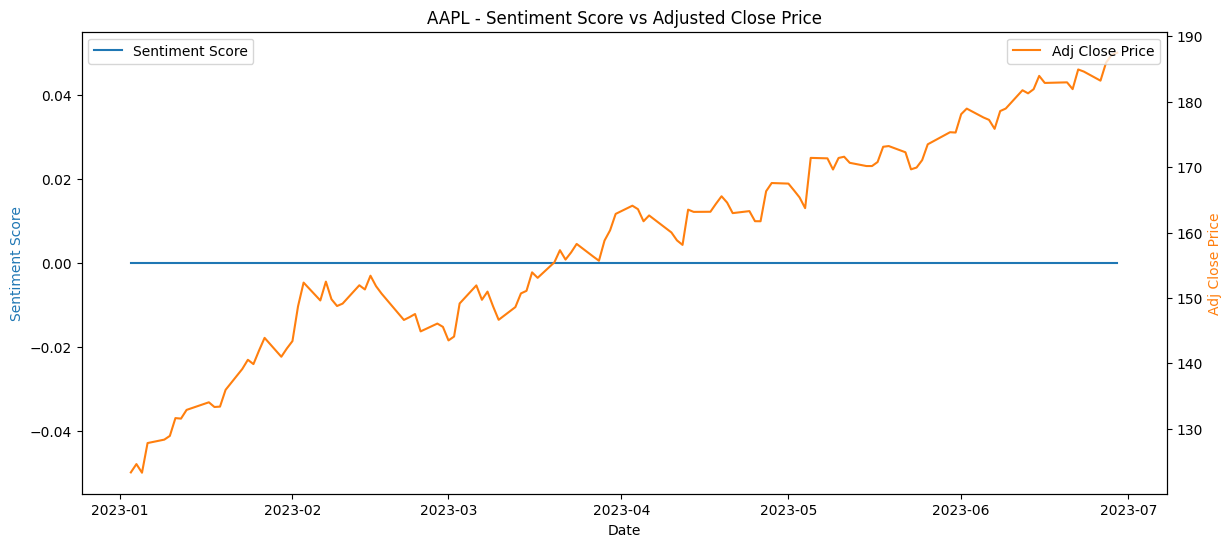

Average next-day returns by sentiment level:
sentiment_bin
Medium    0.003591
Name: next_ret, dtype: float64


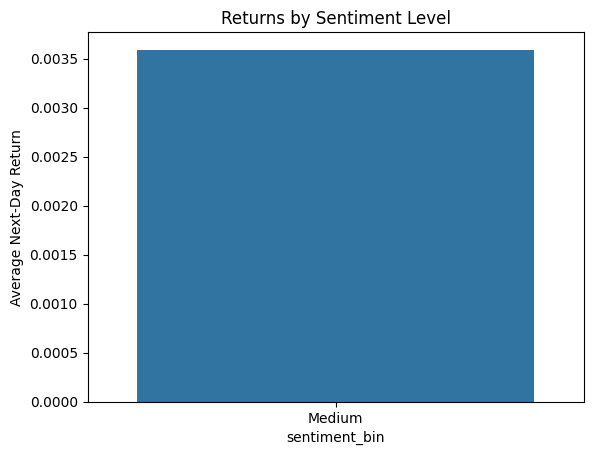

SPY Evaluation:
Average MSE without sentiment: 0.000103
Average MSE with sentiment:    0.000103


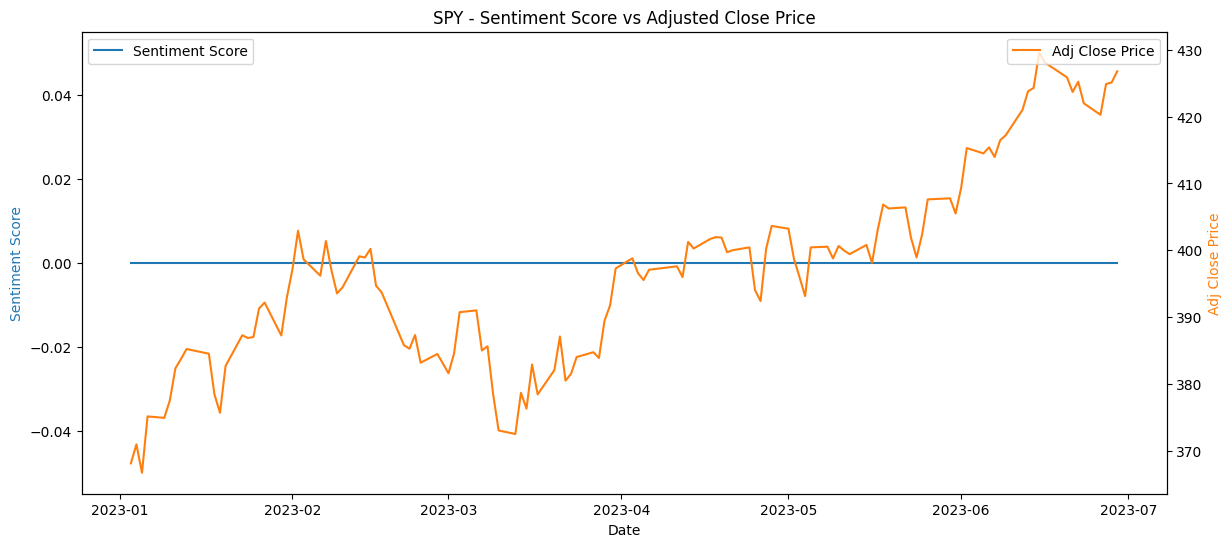

Average next-day returns by sentiment level:
sentiment_bin
Medium    0.001296
Name: next_ret, dtype: float64


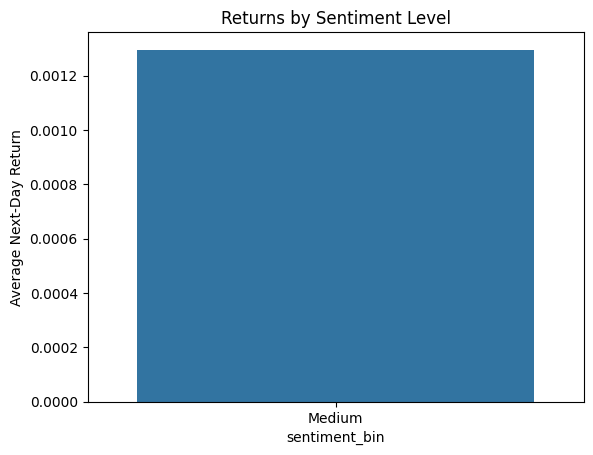

In [ ]:
#Run eval and plots 
print("AAPL Evaluation:")
evaluate_sentiment_impact(X_aapl, "AAPL")
plot_sentiment_vs_price(X_aapl, "AAPL")
compare_returns_by_sentiment(X_aapl)

print("SPY Evaluation:")
evaluate_sentiment_impact(X_spy, "SPY")
plot_sentiment_vs_price(X_spy, "SPY")
compare_returns_by_sentiment(X_spy)

In [ ]:
daily_sent_complete[daily_sent_complete['ticker'] == 'AAPL'].head(10)


,date,ticker,sentiment_score,article_count
